In [1]:
DEBUG = True
MODEL_DEBUG = True
MODEL_IMPROVE_DEBUG = True
GPU_COUNT = 2
WINDOWS = False

In [2]:
!pip install -q einops
!pip install -q pandas
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q opencv-python
!pip install -q scikit-learn

### References

<img src="https://www.testdriller.com/pictures/blog/57043786ab6fa09.jpg" width=700/>

## CIFAR100 Classification

> Can we develop a model that performs well on the benchmark dataset CIFAR100?

### Context

The CIFAR-100 dataset (Canadian Institute for Advanced Research) is a subset of the Tiny Images dataset and consists of <strong>60000</strong> <code>32x32</code> colour images in <strong>100</strong> classes, with <strong>600</strong> images per class. The <strong>100</strong> classes in the CIFAR-100 are <strong>grouped into 20 superclasses</strong>. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). There are <strong>50000 training images</strong> and <strong>10000 test images.</strong>

Credit: <a href="https://www.kaggle.com/datasets/fedesoriano/cifar100?select=meta">Kaggle Link</a>

### Objectives

<ol>
	<li>To explore and understand the CIFAR100 dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performanceo f the model</li>
	<li>Discover new techniques and approaches as to tackle the <strong>3 color-channels (RGB) nature</strong> of the dataset.</li>
	<li>Develop and experiment with models in order to rival state-of-the-art (SOTA) benchmark scores.</li>
</ol>

## Importing Libraries
We import the necessary libraries for the notebook to run below.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import seaborn as sns
sns.set('notebook')
import random

from sklearn.manifold import TSNE

import torch
from torch import nn, optim, einsum
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import os

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


We see the seed such that the notebook results in reproducible results when run.   
We also set the device to CUDA to enable torch to use our GPU.

In [4]:
seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
# Set a fixed value for the hash seed
os.environ['PYTHONHASHSEED'] = str(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)
if device != torch.device('cuda'):
    print('using cpu, exiting')
    assert False

Device available now: cuda


## Utility Functions
Below we define some utility functions that will ease and help us with our analysis.

In [5]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

def imshow(arr: list, label: list = None, figsize=None, shape = (32, 32, 3), is_int = None):
	if is_int == None:
		if type(arr[0]) == torch.Tensor:
			is_int = (arr[0].detach().cpu().numpy() > 1).sum() > 0
		else:
			is_int = (arr[0] > 1).sum() > 0
	if label == None:
		label = [''] * len(arr)

	height = int(len(arr) ** 0.5)
	width = math.ceil(len(arr) / height)

	if figsize == None:
		fig = plt.figure()
	else:
		fig = plt.figure(figsize=figsize)
	for i in range(height):
		for j in range(width):
			ax = fig.add_subplot(height, width, i * height + j + 1)
			ax.grid(False)
			ax.set_xticks([])
			ax.set_yticks([])
			show = arr[i * height + j]
			if type(arr[i * height + j]) != torch.Tensor:
				show = torch.Tensor(show)
				# ax.imshow((arr[i * height + j].squeeze(0).cpu().permute(1, 2, 0) / 255).type(torch.uint8 if is_int else float))
			# if (show.shape[0] == 1):
			# 	ax.imshow((show.squeeze(0).cpu()).type(torch.uint8 if is_int else torch.float), cmap='gray')
			# else:
			if len(show.squeeze(0).cpu().shape) == 2:
				ax.imshow((show.squeeze(0).detach().cpu()).type(torch.uint8 if is_int else torch.float), cmap='gray')
			else:
				ax.imshow((show.squeeze(0).detach().cpu().permute(1,2,0)).type(torch.uint8 if is_int else torch.float))
			ax.set_title(label[i * height + j])

def df_to_tensor(df, shape = (28, 28)):
	return torch.tensor(df.values.reshape((-1, *shape)), dtype=torch.float32)

def preprocess(df):
	return df.copy() / 255

def mse(t1, t2, shape=(28, 28)):
	loss = nn.MSELoss(reduction='none')
	loss_result = torch.sum(loss(t1, t2), dim=2)
	loss_result = torch.sum(loss_result, dim=2)
	loss_result = loss_result / np.prod([*shape])
	return loss_result

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the Kaggle dataset found at <a href="https://www.kaggle.com/datasets/fedesoriano/cifar100">Kaggle Link</a>. 

<table>
	<tr>
		<th>
			Column Name
		</th>
		<th>
			Description
		</th>
	</tr>
	<tr>
		<td>
			label
		</td>
		<td>
			The true class of the image, represented as an integer ranging from 1 to 100<strong>*</strong>
		</td>
	</tr>
	<tr>
		<td>
			pixel 1<br/>...<br/>pixel 3072
		</td>
		<td>
			Pixels representing the image, each pixel ranging from 0 to 255. Each image has a dimension of <code>32x32x3</code>.
		</td>
	</tr>
</table>

<strong>\*</strong>Each number represents a certain dress item
```
1-5 -> beaver, dolphin, otter, seal, whale
6-10 -> aquarium fish, flatfish, ray, shark, trout
11-15 -> orchids, poppies, roses, sunflowers, tulips
16-20 -> bottles, bowls, cans, cups, plates
21-25 -> apples, mushrooms, oranges, pears, sweet peppers
26-30 -> clock, computer keyboard, lamp, telephone, television
31-35 -> bed, chair, couch, table, wardrobe
36-40 -> bee, beetle, butterfly, caterpillar, cockroach
41-45 -> bear, leopard, lion, tiger, wolf
46-50 -> bridge, castle, house, road, skyscraper
51-55 -> cloud, forest, mountain, plain, sea
56-60 -> camel, cattle, chimpanzee, elephant, kangaroo
61-65 -> fox, porcupine, possum, raccoon, skunk
66-70 -> crab, lobster, snail, spider, worm
71-75 -> baby, boy, girl, man, woman
76-80 -> crocodile, dinosaur, lizard, snake, turtle
81-85 -> hamster, mouse, rabbit, shrew, squirrel
86-90 -> maple, oak, palm, pine, willow
91-95 -> bicycle, bus, motorcycle, pickup truck, train
96-100 -> lawn-mower, rocket, streetcar, tank, tractor
```

Below, we refer to the code provided by the official Kaggle link to extract and load the data from the files in the <code>data</code> folder.

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = 'data/meta'
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

data_pre_path = 'data/'

# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
X_train = pd.DataFrame(data_train_dict[b'data'])
y_train = pd.DataFrame(np.array(data_train_dict[b'fine_labels']))
y_train_coarse = pd.DataFrame(np.array(data_train_dict[b'coarse_labels']))
X_test = pd.DataFrame(data_test_dict[b'data'])
y_test = pd.DataFrame(np.array(data_test_dict[b'fine_labels']))
y_test_coarse = pd.DataFrame(np.array(data_test_dict[b'coarse_labels']))

classes = np.array(list(map(lambda x: x.decode('utf-8'), metadata[b'fine_label_names'])))
coarse_classes = np.array(list(map(lambda x: x.decode('utf-8'), metadata[b'coarse_label_names'])))

Let's take a look at the training dataset

In [7]:
X_train.shape

(50000, 3072)

We observe that there are a total of <code>50000</code> rows and <code>3072</code> columns, with each of the columns representing <strong>a single pixel</strong>.

### Testing for missing values and invalid ata
Let's try to identify if there are any missing values

In [8]:
print("Feature missing values:",pd.DataFrame(X_train).isnull().sum().sum())
print("Label missing values:",pd.DataFrame(y_train).isnull().sum().sum())

Feature missing values: 0
Label missing values: 0


### Preprocessing
We perform some transformations such that the channels and dimensions are in the correct format.

In [9]:
temp = np.transpose(X_train.values.reshape((-1, 3, 32, 32)), axes=[0,2,3,1])
X_train = pd.DataFrame(X_train.values.reshape(-1, 3072))

temp = np.transpose(X_test.values.reshape((-1, 3, 32, 32)), axes=[0,2,3,1])
X_test = pd.DataFrame(X_test.values.reshape(-1, 3072))

## Exploratory Data Analysis
In this EDA we'll be attempting to complete the following set of objectives:

### EDA Objectives
<ol>
	<li>Is there any <strong>class imbalance</strong></li>
	<li>What does the <strong>average image</strong> look like?</li>
	<li>Are there <strong>any outlier/anomalies?</strong>
</ol>

Before we begin the EDA, we first need to remove a chunk of the training data to be used as validation dataset in order to avoid data leakage due to the decisions we make during EDA.

### Validation Dataset
Let's make our validation dataset. I decided that I will <strong>not be using cross validation during the modelling process</strong> due to the following reasons:
<ul>
	<li>Time taken to train models, especially if utilising <strong>computationally expensive layers, activation functions or architecture</strong></li>
	<li>Additionally due to the sheer size of the dataset, not only does this add to increased training time but also means there is enough data such that cross validation is not necessary</li>
</ul>

Let's first <strong>take a look at the size of the test dataset</strong>. The shape of the test dataset will be used to <strong>determine the size of the validation set.</strong>

In [10]:
X_test.shape

(10000, 3072)

As the test dataset has a length of <code>10000</code>, we'll <strong>also</strong> make our validation dataset <code>10000</code>.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 10000 / len(X_train), stratify=y_train)

We'll also make sure to select the <strong>same coarse classes</strong>.

In [12]:
y_val_coarse = y_train_coarse.iloc[y_val.index]
y_train_coarse = y_train_coarse.iloc[y_train.index]

We'll use a validation size of <code>10000</code> to mimic the size of the test dataset. We'll also stratify on the <code>label</code> to ensure that the model we generalizes best across all 
the classes.

### Signs of class imbalance?
We'll first identify the siutation with class imbalance

<AxesSubplot: ylabel='Count'>

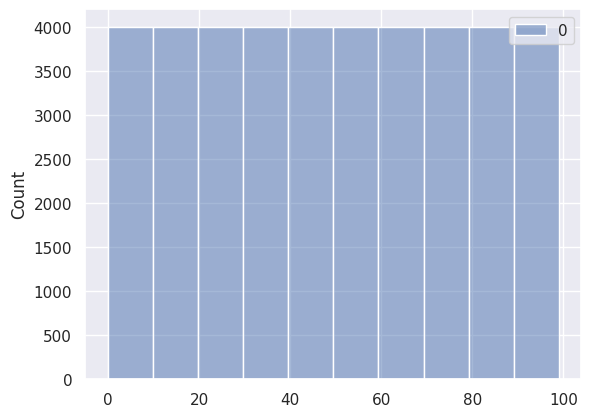

In [13]:
sns.histplot(y_train, bins=10)

We observe that there appears to be <strong>no sign</strong> of class imbalance for the fine labels. What about the coarse labels?

<AxesSubplot: ylabel='Count'>

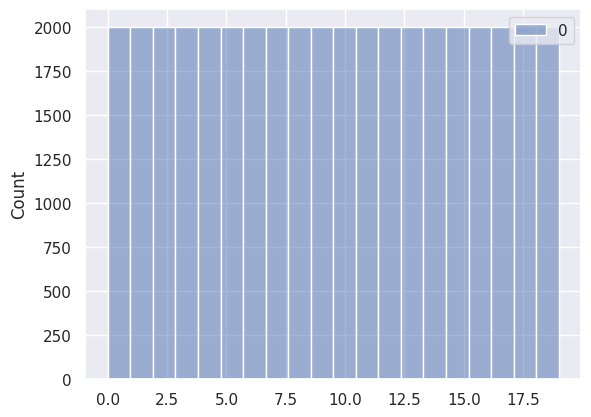

In [14]:
sns.histplot(y_train_coarse, bins=20)

It also appears that there are <strong>no signs of class imbalance</strong> for the coarse labels as well.

### Null values?
We perform a simple <code>.isnull()</code> check to see if there are any null values in any of our data

In [15]:
null_counts = 0
for iter_data in [X_train, y_train, X_val, y_val, X_test, y_test]:
	iter_data = pd.DataFrame(iter_data)
	null_counts += iter_data.isnull().sum().sum()

print("Null counts among ALL the data:", null_counts)

Null counts among ALL the data: 0


We observe that <strong>there are no null values</strong> in the dataset.

### What does the average image look like?
Let's take a look at a random sample of images.

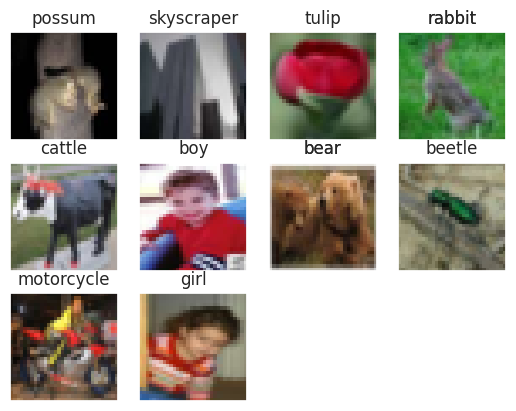

In [16]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train.loc[idx].values.reshape((3, 32, 32)))
	titles.append(classes[y_train.loc[idx].values[0][0]])

imshow(images, titles)

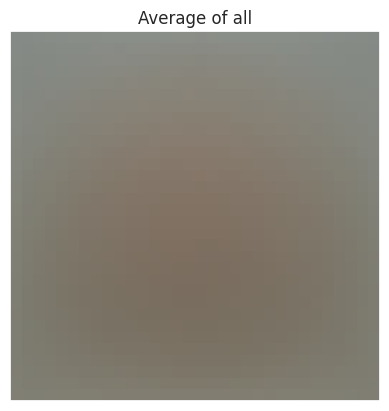

In [17]:
imshow([
	X_train.mean().apply(lambda x: x).values.reshape(3, 32, 32)
], ['Average of all'])

#### Average image among the classes
Next we'll split by the classes and find the average among them.

However, <strong>as our prediction will involve 100 outputs</strong>, what we'll do instead is use the <code>coarse classes</code>, which has 20 classes.

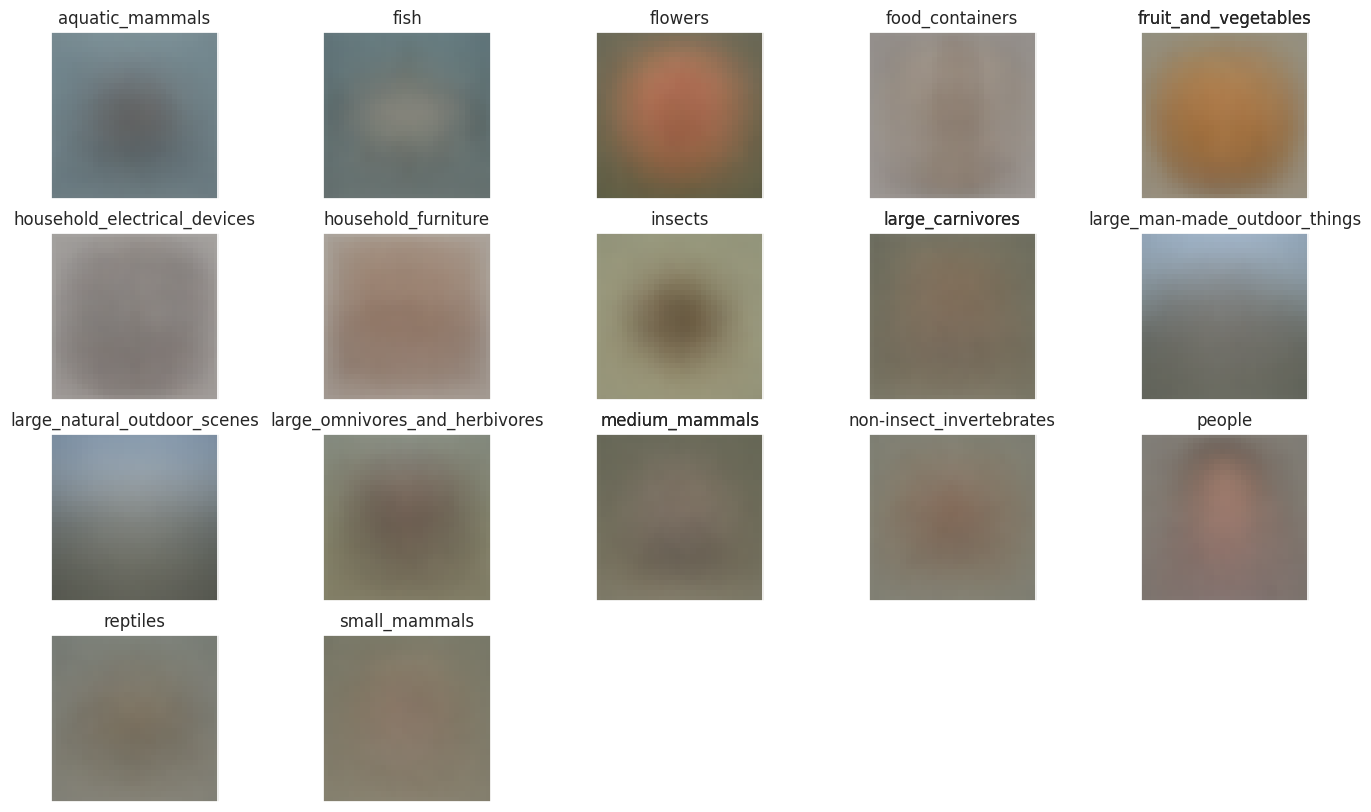

In [18]:
images = []
titles = []

for i in range(20):
	idx = np.where((y_train_coarse.values == i))[0].flatten()
	images.append(X_train.iloc[idx].values.reshape(-1, 3, 32, 32).mean(axis=0))
	titles.append(coarse_classes[i])

imshow(images, titles, figsize = (17, 10))

We observe:
<ul>
	<li>We can <strong>barely make out</strong> the figures for classes such as <code>insects</code>, <code>large_carnivore</code></li>
	<li>We observe a slight silhouette on the <code>people</code> image</li>
	<li>For most of the coarse classes, we can barely make out the shapes</li>
</ul>

Let's try to view the first <code>20 classes</code> from the fine classes.

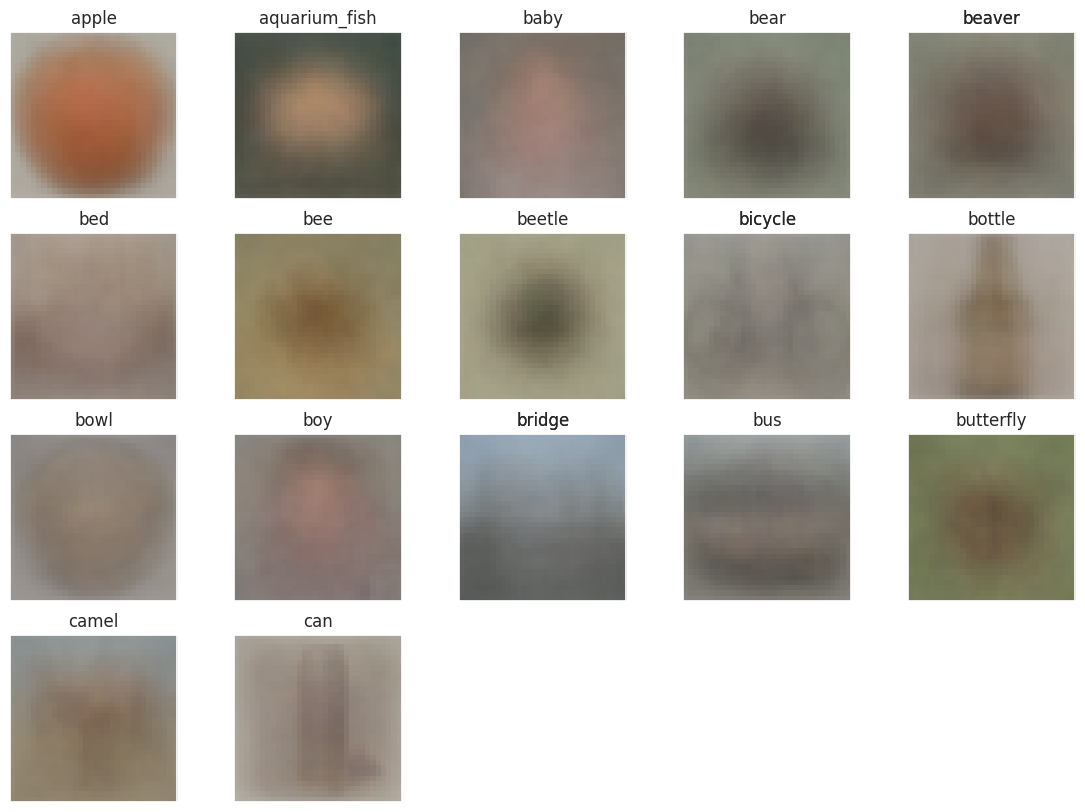

In [19]:
images = []
titles = []

for i in range(20):
	idx = np.where((y_train == i))[0].flatten()
	images.append(X_train.iloc[idx].values.reshape(-1, 3, 32, 32).mean(axis=0))
	titles.append(classes[i])

imshow(images, titles, figsize = (14, 10))

We observe:
<ol>
	<li>We see better resolution in the average images of <code>can</code> and <code>bottle</code> </li>
	<li>Interestingly, we can also recognize the bicycle in the image, alongside its wheels</li>
</ol>

### Are there any outliers/anomalies?
To determine such, one method we can do is to use a Convolution AutoEncoder to <strong>reconstruct</strong> the image. The i dea is that if we restrict the inner layers of the auto encoder, it will be forced to <strong>generalize among all the images</strong>. As such any outlier image will have a <strong>stark difference between the itself and the reconstructed image</strong>.

This "difference" between the images, will be calculated using the <strong>Mean Squared Error (MSE)</strong> between the two images. We use the <strong>squared</strong> to exaggerate the larger errors the autoencoder makes.

<strong>However</strong>, such Convolutioanl AutoEncoders work best for <strong>single-channel</strong> images. As the CIFAR-100 dataset is 3 channels, it is unlikely that Convolutional AutoEncoders will perform well. Additionally, autoencoders are not using information from the labels, which means this approach will tell us how far an image is from the <strong>'general' image</strong>, rather from the general image of it's class.

To tackle this, we'll instead use a ResNet feature extractor, training model to classify. From this, we'll remove the last few layers and use the rich <strong>feature embeddings</strong> in combination with an unsupervised learning method such as TSNE. Doing so, any data points that are <strong>far away from it's class cluster</strong>, suggests it will likely be an outlier.

We'll be using a modified and scaled down version of <strong>ResNet</strong>.

In [20]:
def relu_bn_conv(in_channels, out_channels, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip = False):
        super().__init__()
        self.skip = nn.Sequential()
        self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, padding = 1)

        if skip:
            self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size= 1, stride = 2)

        self.conv2 = relu_bn_conv(out_channels, out_channels, kernel_size = 3, padding = 1)

    def forward(self, x):
        skip = self.skip(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + skip
        return nn.ReLU()(x)

class ResNetS(nn.Module):
    def __init__(self, base_filter = 16):
        super().__init__()

        in_channels = 3
        
        self.l0 = nn.Sequential(
            nn.Conv2d(in_channels, base_filter, kernel_size = 5, stride = 2, padding = 3),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(base_filter),
            nn.ReLU()
        )
        self.l1 = nn.Sequential(
            ResBlock(base_filter, base_filter, skip = False),
            ResBlock(base_filter, base_filter, skip = False),
        )
        self.l2 = nn.Sequential(
            ResBlock(base_filter, base_filter * 2, skip = True),
            ResBlock(base_filter * 2, base_filter * 2, skip = False),
        )
        self.l3 = nn.Sequential(
            ResBlock(base_filter * 2, base_filter * 3, skip = True),
            ResBlock(base_filter * 3, base_filter * 3, skip = False),
        )
        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            torch.nn.Linear(base_filter * 3, 100)
        )

    def forward(self, x):
        x = self.l0(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.gap(x)
        x = self.fc(x)

        return x

#### Loading the dataset
Next we need to load the dataset. In order to do this, below is a custom class that acts as a wrapper <strong>to convert a pandas dataframe to PyTorch tensors</strong>, such that we are able to load the dataset into the <code>DataLoader</code> class.

In [21]:
def to_prob_dist(labels: torch.tensor, size = 100):
	arr = np.full((len(labels), size), 0)
	for i, label in enumerate(labels):
		arr[i][int(label.item())] = 1
	return torch.tensor(arr, dtype=torch.float32)

class TorchDataset(torch.utils.data.Dataset):
	def __init__(self, X, y, X_shape = (3, 32, 32), y_shape = (1, ), y_size = 100, transform = None):
		if (type(X) == torch.Tensor):
			self.x = X
		else:
			self.x = df_to_tensor(X, X_shape)

		self.transform = transform
            
		if (type(y) == torch.Tensor):
			self.y = y
		else:
			self.y = df_to_tensor(y, y_shape)
			self.y = to_prob_dist(self.y, y_size)

		# Transform labels to probability distributions
	
	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		if torch.is_tensor(idx):
			idx = idx.tolist()

		selected = self.x[idx]
            
		if self.transform:
			selected = self.transform(selected)
        
		return selected, self.y[idx]

Now that we have defined our <code>TorchDataset</code>, we'll transform the <code>pd.DataFrame</code> to it to make it easy to use.

In [22]:
train_data = TorchDataset(X_train, y_train)
val_data = TorchDataset(X_val, y_val)

In [23]:
test_data = TorchDataset(X_test, y_test)

#### Training the Feature Extractor

Before we get started training, we <strong>prepare the training environment below.</strong>
This training environment will allow us to train, assess and visualize models with ease.

In [24]:
!pip install tqdm
from tqdm import tqdm

In [25]:
def accurate_count(pred, true):
	return ((pred.argmax(dim=1) == true.argmax(dim=1)).sum()).item()

def perform_augmentation(X_pass, y_pass, transform, n = 2, step = 4000):
	if n == 1:
		X = copy.deepcopy(X_pass)
		X = transform(X)
		final_y = copy.deepcopy(y_pass)
	else:
		X = copy.deepcopy(X_pass)
		y = copy.deepcopy(y_pass)
		final_y = copy.deepcopy(y_pass)
		original_len = len(X)
		for i in range(n - 1):
			transformed_arr = transform(X[:step])
			for j in range(step, original_len, step):
				transformed = transform(X[j:j+step])
				transformed_arr = torch.cat((transformed_arr, transformed), dim = 0)        
			X = torch.cat((X, transformed_arr), dim = 0)
			final_y = torch.cat([final_y, y])
	return X, final_y

class Logger():
	def __init__(self, path = 'plots/log.txt'):
		self.path = path
	
	def log(self, msg):
		file = open(self.path, 'a')
		file.write(str(msg) + '\n')
		file.close()

class Trainer():
	def __init__(self):
		self.saves = {}
		self.loss_tracker = {}
		self.history = pd.DataFrame()

	def show_history(self):
		pass

	def train_model(self, name, model_pass, optimizer_pass, optimizer_args,
					train_data: TorchDataset, model_args = {}, scheduler_pass = None,
					scheduler_args = None, batch_size = GPU_COUNT * 256,
					early_stopping = None, epochs = 200, verbose = False,
					val_data = None, save_model = False, augment = None,
					return_model = False, return_results = False):

		if val_data == None:
			val_data = val_data

		logger = Logger()

		logger.log(model_pass)

		model = model_pass(**model_args)
		model = model.to(device)
		model = nn.DataParallel(model)

		optimizer = optimizer_pass(model.parameters(), **optimizer_args)
		criterion = nn.CrossEntropyLoss()
		train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 0 if WINDOWS else min(12, 4 * GPU_COUNT))
		val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers = 0 if WINDOWS else min(12, 4 * GPU_COUNT))

		if scheduler_pass != None:
			scheduler = scheduler_pass(optimizer, **scheduler_args)

		done = 0
		n_epochs = epochs

		track_loss = np.full((epochs, 4), 0.0, dtype=np.float32) # train acc, train loss, val acc, val loss

		best_performance_df = pd.DataFrame({'Train Loss': 1000, 'Val Loss': 1000, 'Train Acc': 0, 'Val Acc': 0}, index = [name])
		best_val_loss = 1e9
		best_val_acc = 0

		self.end_training = 0
		self.extra_trained = 0

		for epoch in range(1, n_epochs+1):
			# monitor training loss
			train_loss = 0.0
			train_acc_count = 0
			total_sample = 0
			
			###################
			# train the model #
			###################
			model.train()
			for data in tqdm(train_loader):
				# _ stands in for labels, here
				# no need to flatten images
				inputs, labels = data
				inputs = inputs.cuda()
				labels = labels.cuda()

				perform_aug = np.random.random() < 0.4 
				if augment != None and perform_aug:
					batch, perm, lmbd = augment['fn'](inputs.detach().cpu(), *augment['args'], **augment['kwargs'])

					inputs = batch.cuda()
					outputs = model(inputs)

					loss = criterion(outputs, labels) * lmbd + criterion(outputs, labels[perm]) * (1 - lmbd)
				else:
					# forward pass: compute predicted outputs by passing inputs to the model
					outputs = model(inputs)
					# calculate the loss
					loss = criterion(outputs, labels)
					# backward pass: compute gradient of the loss with respect to model parameters
					train_loss += loss.item()
					train_acc_count += accurate_count(outputs, labels)
					total_sample += len(labels)

				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
				
				if scheduler_pass != None and scheduler_pass != optim.lr_scheduler.ReduceLROnPlateau:
					scheduler.step()
					
			train_loss = train_loss/len(train_loader)
			train_acc = train_acc_count / total_sample

			val_loss = 0.0
			val_acc_count = 0
			total_sample = 0
			
			model.eval()
			with torch.no_grad():
				for i, data in enumerate(val_loader):
					inputs, labels = data                             
					inputs = inputs.to(device)
					labels = labels.to(device)

					outputs = model(inputs)
					loss = criterion(outputs, labels)

					val_loss += loss.item()
					val_acc_count += accurate_count(outputs, labels)
					total_sample += len(labels)

			val_loss = val_loss / len(val_loader)
			if scheduler_pass == optim.lr_scheduler.ReduceLROnPlateau:
				scheduler.step(val_loss)
			val_acc = val_acc_count / total_sample

			if verbose:
				print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} \tVal Loss: {val_loss:.5f} \tTrain Acc: {train_acc:.3f} \tVal Acc: {val_acc:.3f}")
			logger.log(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} \tVal Loss: {val_loss:.5f} \tTrain Acc: {train_acc:.3f} \tVal Acc: {val_acc:.3f}")

			track_loss[epoch - 1][0] = train_acc
			track_loss[epoch - 1][1] = train_loss
			track_loss[epoch - 1][2] = val_acc
			track_loss[epoch - 1][3] = val_loss
			done = epoch

			if val_loss < best_val_loss:
				best_performance_df = pd.DataFrame({'Model': model, 'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.end_training = epoch
				best_val_loss = val_loss
				best_val_acc = max(best_val_acc, val_acc)
				if save_model:
					self.save_model(name, model)
			elif val_acc > best_val_acc:
				best_performance_df = pd.DataFrame({'Model': model, 'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.end_training = epoch
				best_val_acc = val_acc
				best_val_loss = min(best_val_loss, val_loss)
				if save_model:
					self.save_model(name, model)

			if early_stopping != None:
				early_stopping(val_loss, val_acc)

			if early_stopping != None and early_stopping.stop:
				if (verbose):
					print(f"Stopping due to early stopping | patience = {early_stopping.patience}")
				logger.log(model_pass)
				break


		track_loss.resize((done, 4))
		self.record(name, track_loss, best_performance_df)


		if return_model:
			del train_loader, val_loader, inputs, labels
			torch.cuda.empty_cache()
			if return_results:
				return model, best_performance_df['Val Acc'].values[0]
			return model
		else:
			del model, optimizer, train_loader, val_loader, inputs, labels
			torch.cuda.empty_cache()

	def record(self, name, track_loss, best_performance_df):
		track_loss_df = pd.DataFrame(track_loss, columns=['Train Acc', 'Train Loss', 'Val Acc', 'Val Loss'])
		track_loss_df.index += 1
		track_loss_df.index.name = 'Epoch'

		try:
			self.history = pd.read_csv('plots/record.csv')
		except:
			self.history = pd.DataFrame()

		self.history = pd.concat([self.history, best_performance_df], axis=0)
		self.history.to_csv('plots/record.csv')
		self.loss_tracker[name] = track_loss_df

	def save_model(self, name, model):
		self.saves[name] = copy.deepcopy(model)

	def get_model(self, name):
		return copy.deepcopy(self.saves[name])

	def archive(self, name):
		fig = plt.figure(figsize=(14, 5))
		train, val = sns.color_palette('Set2')[0:2]
		loss, acc = fig.subplots(1, 2)

		loss.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 

		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Loss'], label='Train', color=train)
		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Loss'], label='Val', color=val)
		loss.set_xlabel('Epoch')
		loss.set_ylabel('Loss')

		acc.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Acc'], label='Train', color=train)
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Acc'], label='Val', color=val)

		acc.set_xlabel('Epoch')
		acc.set_ylabel('Accuracy')

		acc.legend()
		loss.legend()
		
		fig.savefig(f'plots/{name}.png')
		plt.close()
		del self.loss_tracker[name]

We'll train our feature extractor for 50 epochs.

In [26]:
if not DEBUG:
	trainer = Trainer(nn.CrossEntropyLoss)
	res_model = trainer.train_model(
		'ResNet-S Feature Extractor', ResNetS, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		epochs = 50,
		# verbose=True,
		return_model = True
	)
	trainer.archive('ResNet-S Feature Extractor')
	display(trainer.history)

Now that we have a trained a simple and small ResNet feature extractor, we can <strong>use its feature mapping</strong>. We cut off the last layers of the model below.

In [27]:
if not DEBUG:
	feature_extractor = torch.nn.Sequential(*(list(list(res_model.children())[0].children())[:-2]))

We then load our data into a dataloader. This is because giving all the images to the model at once for inference will lead to <strong>insufficient memory</strong>. We'll also store information into a <code>pd.DataFrame</code> such that we can pass this information to <strong><code>TSNE</code> to perform manifold learning</strong>.

<strong>Why <code>TSNE</code>?</strong>  

I decided to use TSNE because it allows for non-linear relationships where as a dimensionality reduction technique such as <code>PCA</code> only performs well for linear relationships inside the data.

In [28]:
if not DEBUG:
	output = pd.DataFrame()
	batch_size = 100
	train_loader = DataLoader(train_data, batch_size = batch_size)
	for data in train_loader:
		image, label = data
		output = pd.concat([output, pd.DataFrame(feature_extractor(image).detach().cpu().numpy().reshape(batch_size, -1))], axis=0)

Below we use <code>MulticoreTSNE</code>, which is a <strong>faster implementation</strong> of Sklearn's <code>TSNE</code>, despite Sklearn also implementing multicore support with <code>n_jobs</code>. We also <strong>set the number of components to be 4</strong>, as not only does the dataset have a lot of classes, but contains a lot of information.

In [29]:
if not DEBUG:
	from MulticoreTSNE import MulticoreTSNE as TSNE
	tsne = TSNE(n_components = 4, method='exact', n_jobs=-1)
	results = tsne.fit_transform(output)

Next, we need to calculate how far each image is from the 'mean' of its images.

In [30]:
if not DEBUG:
	y_train.columns = ['label']
	tsne_df = pd.concat([pd.DataFrame(results), y_train], axis=1)
	tsne_means = tsne_df.groupby(by='label').mean()
	tsne_means.columns = ['mean_0', 'mean_1', 'mean_2', 'mean_3']
	distance_tsne = tsne_df.join(tsne_means, on='label')
	distance_tsne['dist_from_mean'] = ((distance_tsne[[0, 1, 2, 3]].values - distance_tsne[['mean_0', 'mean_1', 'mean_2', 'mean_3']].values) ** 2).sum(axis=1)

After calculating the distance, we'll now inspect what <strong>our "Outlier Detection" method</strong> reveals about the dataset.

In [31]:
if not DEBUG:
	farthest_idx = distance_tsne.sort_values(by='dist_from_mean', ascending = False).iloc[0:16].index
	closest_idx = distance_tsne.sort_values(by='dist_from_mean', ascending = True).iloc[0:16].index

We'll first <strong>inspect images</strong> that the algorithm considers to be <strong>far way</strong> from its respective class.

In [32]:
if not DEBUG:
	imshow(train_data.x[farthest_idx].cpu().numpy(), classes[np.argmax(train_data.y[farthest_idx].cpu().numpy(), axis=1)].tolist(), figsize=(7, 7))

We observe:
<ul>
	<li>The first thing we see is that <code>orchid</code> and <code>sunflower</code> are blue, indicating <strong>outliers in the form of colors</strong></li>
	<li>This suggests that the color channels for these two particular images and incorrect, and implies that performing <strong>color altering augmentation</strong> is likely going to benefit our model performance</li>
	<li>We also observe there to be quite a few <code>dolphins</code>, <code>shark</code>, and <code>whale</code>.</li>
	<li>This may be due to our model's feature maps being incorrect, for instance assigning said dolphin a feature map of a shark, resulting to a large distance away from the dolphin's mean vectors.</li>
</ul>

It is likely that using a better performing feature extractor will lead to better results, as it seems the modified ResNet-S does not have the model capacity to be able to distinguish between closely related classes.

Next, we'll analyse the <strong>closest images</strong> to the mean.

In [33]:
if not DEBUG:
	imshow(train_data.x[closest_idx].cpu().numpy(), classes[np.argmax(train_data.y[closest_idx].cpu().numpy(), axis=1)].tolist(), figsize=(7, 7))

We observe:
<ul>
	<li>Most of the images are <code>plain</code> and <code>sea</code>, which tells us the model was easily able to extract features effectively</li>
	<li>This is highly likely due to the fact that the <code>separation between the sky and the earth</code>, results to <strong>easy identification</strong></li>
	<li>Trees appear to also be easily identifiable.</li>
</ul>

#### What about coarse classes?

As our model is still not quite robust, such as giving similar feature maps to dolphins and sharks, perhaps more <strong>coarse labels</strong> will result in better identification of outliers.

### Would <strong>rotational data augmentation</strong> be of use?
Convolutional Neural Networks are proven to have the property of <strong>translation invariance</strong> and <strong>translation equivariance</strong>, which means regardless of the translations performed on the image, the feature map of the CNN will be also translated. Essentially,

$$c(t(x)) = t(c(x))$$

Where $t$ represents translation and $c$ represents the convolutional network.

However, CNN do not have any invariance to rotational. Would performing rotational data augmentation be of use? To find this out, <strong>I designed a custom algorithm</strong> to detect whether there exists rotated images. We'll specifically be using the algorithm on the class of <code>cans</code> because it is easier to detect for rotated images (as cans are usually upright).

The idea is this:
<ol>
	<li>Apply <strong>vertical convlutional layer</strong> to the original image, to <strong>extract vertical lines</strong></li>
	<li>Apply <strong>horizontal convlutional layer</strong> to the original image, to <strong>extract horizontal lines</strong></li>
	<li>Then from these outputs of the 2 convolutional layers, we want to find out what the <strong>"longest line"</strong> is</li>
	<li>If the vertical output has a longer line than the horizontal output, the image is likely to be upright, and vice versa</li>
</ol>

We define the <strong>horizontal and vertical convolution weights</strong> below.

In [34]:
vert_weights = torch.Tensor(
    [[1, 0, -1], [1, 0, -1], [1, 0, -1]]
).unsqueeze(0).unsqueeze(0)
vert_weights.requires_grad = True

vert_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)

with torch.no_grad():
    vert_conv.weight = nn.Parameter(vert_weights)

vert_conv = vert_conv.cuda()

hori_weights = torch.Tensor(
    [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]
).unsqueeze(0).unsqueeze(0)
hori_weights.requires_grad = True

hori_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)

with torch.no_grad():
    hori_conv.weight = nn.Parameter(hori_weights)

hori_conv = hori_conv
hori_layer = nn.Sequential(
    hori_conv,
    nn.BatchNorm2d(1)
).cuda()

Next, we restrict the space of images to only those that have the <code>can</code> label.

In [35]:
idx = np.where(y_train == 16)[0]
cans_x = train_data.x[idx]

As an example, let's interpret what the two <strong>vertical and horizontal convolutional filters</strong> are doing.

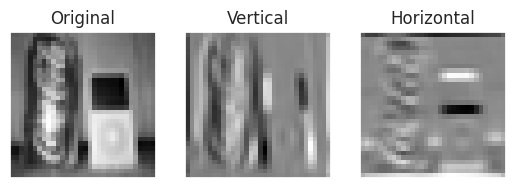

In [36]:
gray_cans = transforms.functional.rgb_to_grayscale(cans_x, 1)

gray_can_example = gray_cans[0]
hori = hori_conv(gray_can_example.cuda())
vert = vert_conv(gray_can_example.cuda())

imshow([gray_can_example, vert, hori], label=['Original', 'Vertical', 'Horizontal'], is_int = False)

We see that because the <strong>vertical output has "longer" lines</strong>, this means the image is <strong>likely to be upright</strong>, which is the case.

Thus, we'll continue to <strong>define</strong> our algorithm in a function, <strong>apply</strong> the function to all the <code>can</code> images in the training dataset, and then <strong>visualize</strong> them to perform a check on rotated images.

In [37]:
horizontal_images = []

def color_diff_lengths(image, orientation = 'hori'):
		if len(image.shape) == 3:
			image = image.reshape(32, 32)

		if orientation == 'hori':
			image = image[1:-1, :]
			means = image.mean(axis=1)
			left = np.argmax(np.apply_along_axis(lambda x: x <= means, 0, image), axis=1)
			right = (image.shape[1] - 1) - np.argmax(np.apply_along_axis(lambda x: x >= means, 0, image[:, ::-1]), axis=1)
		else:
			image = image[:, 1:-1]
			means = image.mean(axis=0)
			left = np.argmax(np.apply_along_axis(lambda x: x <= means, 1, image), axis=0)
			right = (image.shape[0] - 1) - np.argmax(np.apply_along_axis(lambda x: x >= means, 1, image[::-1, :]), axis=0)

		return max(right - left)

for img in gray_cans:
	vertical_length = color_diff_lengths(vert_conv(img.cuda()).detach().cpu().numpy().transpose(1, 2, 0), orientation = 'vert')
	horizontal_length = color_diff_lengths(hori_conv(img.cuda()).detach().cpu().numpy().transpose(1, 2, 0), orientation = 'hori')

	if horizontal_length > vertical_length:
		horizontal_images.append(img.cpu().numpy())

Let's take a look at the images

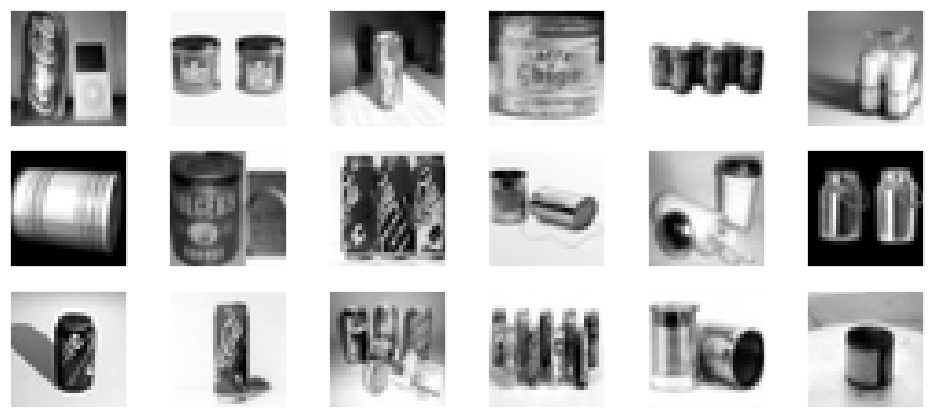

In [38]:
imshow(horizontal_images, shape=(32, 32), figsize = (12, 7))

We observe:
<ul>
	<li>Our algorithm is not completely robust, <strong>there are instances of upright cans</strong></li>
	<li>However, there are also <strong>many upright cans</strong>, stacked in a horizontal manner</strong>, leading to our algorithm believing that they are horizontal</li>
	<li>There are a few images of a combination of horizontal cans and vertical cans, with one image of a horizontal can</li>
</ul>

As this can likely extend to other classes (maybe even more likely, e.g. dolphin swimming up and dolphin swimming towards the right), we conclude that <strong>rotational augmentation</strong> will definitely help with our model.

## Feature Engineering
Before we proceed with anything else, we'll first <strong>normalize</strong> the data. This means we'll divide every value in the dataset by <code>255</code>.

In [39]:
X_val /= 255.0

## Data Augmentation
For data augmentation we <strong>note from EDA that:</strong>
<ul>
	<li>Rotational augmentation are likely to be useful (at least for <code>cans</code>)</strong>
	<li>Color augmentations are also useful</strong>
</ul>

As such we'll with performing an <strong>augmentation algorithm</strong> called <strong>AugMix</strong>

In [40]:
t_dtype = transforms.Lambda(lambda x: x.float() / 255.0 if (x > 1).sum() > 0 else x)

t_base = transforms.Compose([
	t_dtype,
	transforms.RandomCrop(32, padding=3),
	transforms.RandomHorizontalFlip(p=0.5),
])

t_augmix = transforms.Compose([
	transforms.Lambda(lambda x: x.type(torch.uint8) if (x > 1).sum() > 0 else (x * 255).type(torch.uint8)),
	transforms.AugMix(severity=5, mixture_width = 5),
	transforms.Lambda(lambda x: x.float() / 255.0),
])

t_extra_augmix = transforms.Compose([
	t_augmix,
	t_dtype,
	transforms.RandomCrop(32, padding=3),
	transforms.RandomHorizontalFlip(p=0.5),
	transforms.RandomRotation((-30, 30))
])

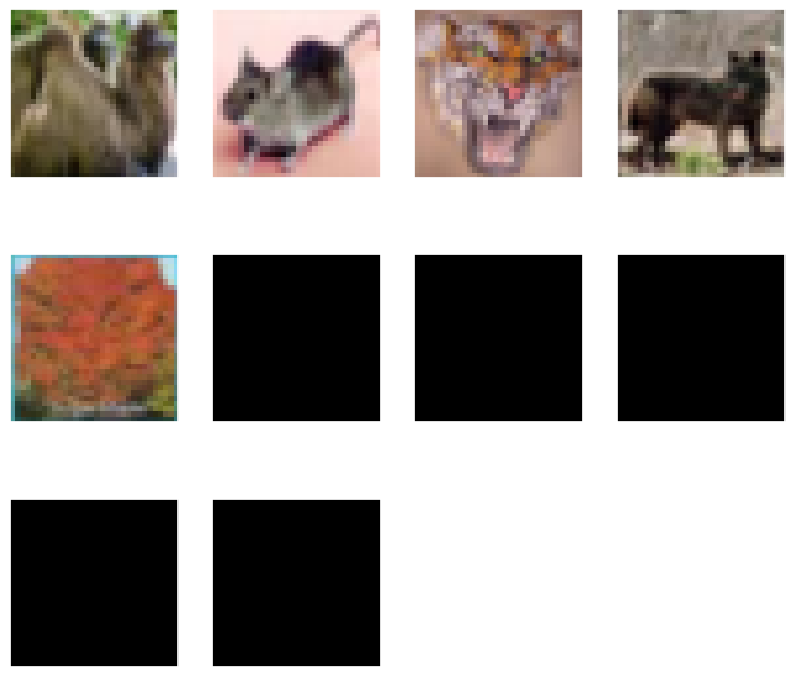

In [41]:
aug_X, aug_y = perform_augmentation(train_data.x[0:5], train_data.y[0:5], t_extra_augmix, step = 1)
imshow(aug_X, figsize = (10, 9))

In [42]:
base_train_data = TorchDataset(X_train, y_train, transform = t_base)
aug_train_data = TorchDataset(X_train, y_train, transform = t_extra_augmix)

## Modelling

### Metric
We'll be using two metrics: <strong>Accuracy</strong> and <strong>Categorical Crossentropy</strong>

$$accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

$$\text{categorical crossentropy} = -\sum_{i=1}^{n}y_i \log{(p_i)} $$

We use accuracy to choose the model, as the benchmarks for the CIFAR100 dataset are in terms of accuracy. Additionally, the dataset does not have an imbalanced class issue, thus using accuracy is not unsuitable.

We use categorical crossentropy as our criterion to train the model, because it heavily penalizes models that are confident and wrong in their prediction. This is due to the logarithmic function in the cross entropy formula. 

#### Custom Early Stopping
Additionally, instead of <strong>arbitrarily choosing the number of epochs</strong> or fine tuning it (which computationally will take long), I decided to use <strong>Early Stopping</strong> as a mechanism.

Overfitting is something that occurs when a model begins to extract some of the residual variation such as noise under the assumption that it is learning the patterns (Burnham and Anderson, 2010). Essentially, it starts to <strong>memorize instead of generalize</strong>. Traditional Early Stopping attempts to combat overfitting by stopping training if the performance/loss of the model on a validation set does not improve over $n$ epochs, where $n$ is the patience parameter. However, it requires <strong>clever tuning</strong> to prevent underfitting (Adam, 2018). As such to address this problem, I use a custom implemented early stopping class inspired by this <a href="https://alexadam.ca/2018/08/03/early-stopping/">article</a>.

The idea of this custom early stopping is that we <strong>only stop training</strong> if there are no improvements in <strong>both loss and accuracy</strong>. If there is an improve in any of the single quantities, the patience counter is reset. This tackles the issue of the underlying assumption that <strong>"loss is correlated with accuracy</strong>", and becomes a more lenient form of early stopping, ideally decreasing underfitting.

In [43]:
class CustomEarlyStopping():
	def __init__(self, patience, min_loss_delta = 0, min_acc_delta = 0):
		self.patience = patience
		self.best_loss = 1e9
		self.best_acc = 0
		self.patience_count = 0
		self.count = 0
		self.stop = False

		self.min_loss_delta = min_loss_delta
		self.min_acc_delta = min_acc_delta

	def __call__(self, loss, accuracy):
		self.save_state = False

		if self.best_loss - loss > self.min_loss_delta or accuracy - self.best_acc > self.min_acc_delta:
			if self.best_loss - loss > self.min_loss_delta:
				self.best_loss = loss
			if accuracy - self.best_acc > self.min_acc_delta:
				self.best_acc = accuracy

			self.count = 0
		else:
			self.count += 1
		
		if self.count >= self.patience:
			self.stop = True


In [44]:
trainer = Trainer()

### Model Architectures

In this assignment, we are to investigate both the datasets for <strong>fine</strong> and <strong>coarse</strong> labels. Although the intuition is that <strong>any model that performs well on fine labels, will perform on the coarse labels</strong> (due to the differences being quite literally one more dense layer), it is important to really investigate and check if this is true. We'll tackle this later.

For now, let's first attempt to find appropriate model architectures to solve the problem of <strong>fine labels(100 classes)</strong>.

#### Baseline NN

As a reference point, we'll see how a baseline neural network consisting of only neurons will perform.

It consists of:
<ol>
	<li>Linear layer</li>
	<li>Batch Normalization</li>
	<li>ReLU activation function</li>
</ol>

In [45]:
def fc_block(in_feat, out_feat):
	return nn.Sequential(
		nn.Linear(in_feat, out_feat),
		nn.BatchNorm1d(out_feat),
		nn.ReLU()
	)

class BaselineNN(nn.Module):
	def __init__(self, num_classes):
		super(BaselineNN, self).__init__()
		self.flat = nn.Flatten(1)
		self.b1 = fc_block(3072, 1536)
		self.b2 = fc_block(1536, 768)
		self.b3 = fc_block(768, 384)
		self.b4 = fc_block(384, 192)
		self.b5 = fc_block(192, num_classes)

	def forward(self, x):
		x = self.flat(x)
		x = self.b1(x)
		x = self.b2(x)
		x = self.b3(x)
		x = self.b4(x)
		x = self.b5(x)
		return x

In [46]:
trainer = Trainer()
batch_num = len(DataLoader(aug_train_data, batch_size = GPU_COUNT * 256))

if not MODEL_DEBUG:
	trainer.train_model(
		'AugMix + Baseline NN', BaselineNN, # model
		optim.AdamW, {'lr': 1e-4 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		aug_train_data, # data
		early_stopping = CustomEarlyStopping(patience = 7),
		verbose=True
	)
	trainer.archive('AugMix + Baseline NN')
	display(trainer.history)

![](plots/AugMix%20%2B%20Baseline%20NN.png)

#### AlexNet-inspired CNN: MiniAlexNet

In [47]:
class MiniAlexNet(nn.Module):
	def __init__(self, num_classes = 100):
		super(MiniAlexNet, self).__init__()

		self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
		)

		self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, stride=2, padding=2),
            nn.ReLU(),
		)

		self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
		)

		self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
			nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
		)

		self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

		self.fc = nn.Sequential(
			nn.Dropout(p = 0.5),
			nn.Linear(256 * 2  * 2, 1024),
			nn.ReLU(),
			nn.Dropout(p = 0.5),
			nn.Linear(1024, 1024),
			nn.ReLU(),
			nn.Linear(1024, num_classes)
		)

	def forward(self, x):
		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = self.conv4(x)
		x = self.avgpool(x)
		x = torch.flatten(x, 1)
		x = self.fc(x)
		return x

In [48]:
if not MODEL_DEBUG:
	trainer.train_model(
		'AugMix + MiniAlexNet', MiniAlexNet, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		aug_train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('AugMix + MiniAlexNet')
	display(trainer.history)

![](plots/AugMix%20%2B%20MiniAlexNet.png)

#### Modified VGG15
From our past experiment, VGG15 worked incredibly well.

In [49]:
def VGGBlock(in_channels, out_channels, pool = False, activation = nn.ReLU):
	if pool:
		return nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
			nn.BatchNorm2d(out_channels),
			activation(),
			nn.MaxPool2d(kernel_size = 2, stride = 2)
		)
	return nn.Sequential(
		nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
		nn.BatchNorm2d(out_channels),
		activation()
	)

class VGG15(nn.Module):
	def __init__(self, num_classes = 100):
		super().__init__()
		self.l0 = VGGBlock(3, 64)
		self.l1 = VGGBlock(64, 64)
		self.l2 = VGGBlock(64, 64, pool = True)
		self.l3 = VGGBlock(64, 128)
		self.l4 = VGGBlock(128, 128)
		self.l5 = VGGBlock(128, 128, pool = True)
		self.l6 = VGGBlock(128, 256)
		self.l7 = VGGBlock(256, 256)
		self.l8 = VGGBlock(256, 256, pool = True)
		self.l9 = VGGBlock(256, 512)
		self.l10 = VGGBlock(512, 512)
		self.l11 = VGGBlock(512, 512, pool = True)
        
		self.flat = nn.Flatten(start_dim = 1)
		self.drop_layer0 = nn.Dropout(0.5)
		self.fc0 = nn.Sequential(
			nn.Linear(512 * 2 * 2, 4096),
			nn.ReLU()
		)
        
		self.drop_layer1 = nn.Dropout(0.5)    
		self.fc1 = nn.Sequential(
			nn.Linear(4096, 4096),
			nn.ReLU()
		)
        
		self.fc2 = nn.Sequential(
			nn.Linear(4096, num_classes)
		)


	def forward(self, x):
		x = self.l0(x)
		x = self.l1(x)
		x = self.l2(x)
		x = self.l3(x)
		x = self.l4(x)
		x = self.l5(x)
		x = self.l6(x)
		x = self.l7(x)
		x = self.l8(x)
		x = self.l9(x)
		x = self.l10(x)
		x = self.l11(x)
		x = self.flat(x)
		x = self.drop_layer0(x)
		x = self.fc0(x)
		x = self.drop_layer1(x)
		x = self.fc1(x)
		x = self.fc2(x)
		return x
    
	def __repr__(self):
		return "VGG15"

In [50]:
if not MODEL_DEBUG:
	trainer = Trainer()
	trainer.train_model(
		'AugMix + VGG15', VGG15, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		aug_train_data, # data
		# scheduler_pass = torch.optim.lr_scheduler.StepLR,
		# scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('AugMix + VGG15')
	display(trainer.history)

![](plots/AugMix%20%2B%20VGG15.png)

#### AugMix + ResNet50

The next model we try is ResNet50. The issue with VGG is that it suffers from the <strong>vanishing gradient</strong> problem. Although sometimes it may not have an effect on the performance (such as seen with the FashionMNIST dataset), we'll.

As ResNet has 'skip' blocks, essentially countering the <strong>vanishing gradient</strong> issue, it means we can have a deeper network that does not suffer from the problem.

In [51]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 2
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet50(nn.Module):

    def __init__(self, block = BottleNeck, num_block = [3, 4, 6, 3], num_classes=100):
        super().__init__()
        block = BottleNeck
        num_block = [3, 4, 6, 3]

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = self.dropout(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output


In [52]:
if not MODEL_DEBUG:
	trainer.train_model(
		'AugMix + ResNet50', ResNet50, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT ** 0.5), 'weight_decay': 1e-5}, # optimizer
		aug_train_data, # data
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		early_stopping = CustomEarlyStopping(patience = 10),
		verbose=True
	)
	trainer.archive('AugMix + ResNet50')
	display(trainer.history)

![](plots/AugMix%20%2B%20ResNet50.png)

#### EfficientNet B0
EfficientNet uses an MBConv block, inspired by the residual block. This architecture is not only efficient but performs better than traditional previously novel convolutional neural networks.
The traditional EfficientNet B0 like all other models, simply down samples too fast, as the architecture is intended for <code>224 x 244</code> and so the idea is that <strong>downsampling fast</strong>, will immediately move past the incredibly fine details. 

However, this is not useful in our case, as CIFAR100 consists of <code>32 x 32</code> images. As such, we consider the pixels themselves to provide a good amount of information and thus performing <strong>fast and aggresive downsampling</strong> will actually lead to abysmal performance.

In [53]:
from torch.nn.parameter import Parameter
import torch.nn.functional as F

class Swish(nn.Module):
    def __init__(self, train_beta=False):
        super(Swish, self).__init__()
        if train_beta:
            self.weight = Parameter(torch.Tensor([1.]))
        else:
            self.weight = 1.0

    def forward(self, x):
        return x * torch.sigmoid(self.weight * x)

class SqueezeExcitation(nn.Module):
    def __init__(self, inplanes, se_ratio):
        super(SqueezeExcitation, self).__init__()
        hidden_dim = int(inplanes*se_ratio)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(inplanes, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, inplanes, bias=False)
        self.swish = Swish()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.avg_pool(x).view(x.size(0), -1)
        out = self.fc1(out)
        out = self.swish(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.unsqueeze(2).unsqueeze(3)
        out = x * out.expand_as(x)
        return out


class Bottleneck(nn.Module):
    def __init__(self,inplanes, planes, kernel_size, stride, expand, se_ratio, prob=1.0):
        super(Bottleneck, self).__init__()
        if expand == 1:
            self.conv2 = nn.Conv2d(inplanes*expand, inplanes*expand, kernel_size=kernel_size, stride=stride,
                                   padding=kernel_size//2, groups=inplanes*expand, bias=False)
            self.bn2 = nn.BatchNorm2d(inplanes*expand, momentum=0.99, eps=1e-3)
            self.se = SqueezeExcitation(inplanes*expand, se_ratio)
            self.conv3 = nn.Conv2d(inplanes*expand, planes, kernel_size=1, bias=False)
            self.bn3 = nn.BatchNorm2d(planes, momentum=0.99, eps=1e-3)
        else:
            self.conv1 = nn.Conv2d(inplanes, inplanes*expand, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm2d(inplanes*expand, momentum=0.99, eps=1e-3)
            self.conv2 = nn.Conv2d(inplanes*expand, inplanes*expand, kernel_size=kernel_size, stride=stride,
                                   padding=kernel_size//2, groups=inplanes*expand, bias=False)
            self.bn2 = nn.BatchNorm2d(inplanes*expand, momentum=0.99, eps=1e-3)
            self.se = SqueezeExcitation(inplanes*expand, se_ratio)
            self.conv3 = nn.Conv2d(inplanes*expand, planes, kernel_size=1, bias=False)
            self.bn3 = nn.BatchNorm2d(planes, momentum=0.99, eps=1e-3)

        self.swish = Swish()
        self.correct_dim = (stride == 1) and (inplanes == planes)
        self.prob = torch.Tensor([prob])

    def forward(self, x):
        if self.training:
            if not torch.bernoulli(self.prob):
                # drop
                return x

        if hasattr(self, 'conv1'):
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.swish(out)
        else:
            out = x

        out = self.conv2(out) # depth wise conv
        out = self.bn2(out)
        out = self.swish(out)

        out = self.se(out)


        out = self.conv3(out)
        out = self.bn3(out)

        if self.correct_dim:
            out += x

        return out


class MBConv(nn.Module):
    def __init__(self, inplanes, planes, repeat, kernel_size, stride, expand, se_ratio, sum_layer, count_layer=None, pl=0.5):
        super(MBConv, self).__init__()
        layer = []

        # not drop(stchastic depth)
        layer.append(Bottleneck(inplanes, planes, kernel_size, stride, expand, se_ratio))

        for l in range(1, repeat):
            if count_layer is None:
                layer.append(Bottleneck(planes, planes, kernel_size, 1, expand, se_ratio))
            else:
                # stochastic depth
                prob = 1.0 - (count_layer + l) / sum_layer * (1 - pl)
                layer.append(Bottleneck(planes, planes, kernel_size, 1, expand, se_ratio, prob=prob))

        self.layer = nn.Sequential(*layer)

    def forward(self, x):
        out = self.layer(x)
        return out

class Flatten(nn.Module):
    def __init(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)


class EfficientNet(nn.Module):
    def __init__(self, num_classes=1000, width_coef=1., depth_coef=1., scale=1.,
                 dropout_ratio=0.2, se_ratio=0.25, stochastic_depth=False, pl=0.5):

        super(EfficientNet, self).__init__()
        channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        expands = [1, 6, 6, 6, 6, 6, 6]
        repeats = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 1, 2, 1, 1, 2, 1]
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]
        depth = depth_coef
        width = width_coef


        channels = [round(x*width) for x in channels] # [int(x*width) for x in channels]
        repeats = [round(x*depth) for x in repeats] # [int(x*width) for x in repeats]

        sum_layer = sum(repeats)

        self.swish = Swish()

        self.stage1 = nn.Sequential(
            nn.Conv2d(3, channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3))

        if stochastic_depth:
            # stochastic depth
            self.stage2 = MBConv(channels[0], channels[1], repeats[0], kernel_size=kernel_sizes[0],
                                 stride=strides[0], expand=expands[0], se_ratio=se_ratio, sum_layer=sum_layer,
                                 count_layer=sum(repeats[:0]), pl=pl)
            self.stage3 = MBConv(channels[1], channels[2], repeats[1], kernel_size=kernel_sizes[1],
                                 stride=strides[1], expand=expands[1], se_ratio=se_ratio, sum_layer=sum_layer,
                                 count_layer=sum(repeats[:1]), pl=pl)
            self.stage4 = MBConv(channels[2], channels[3], repeats[2], kernel_size=kernel_sizes[2],
                                 stride=strides[2], expand=expands[2], se_ratio=se_ratio, sum_layer=sum_layer,
                                 count_layer=sum(repeats[:2]), pl=pl)
            self.stage5 = MBConv(channels[3], channels[4], repeats[3], kernel_size=kernel_sizes[3],
                                 stride=strides[3], expand=expands[3], se_ratio=se_ratio, sum_layer=sum_layer,
                                 count_layer=sum(repeats[:3]), pl=pl)
            self.stage6 = MBConv(channels[4], channels[5], repeats[4], kernel_size=kernel_sizes[4],
                                 stride=strides[4], expand=expands[4], se_ratio=se_ratio, sum_layer=sum_layer,
                                 count_layer=sum(repeats[:4]), pl=pl)
            self.stage7 = MBConv(channels[5], channels[6], repeats[5], kernel_size=kernel_sizes[5],
                                 stride=strides[5], expand=expands[5], se_ratio=se_ratio, sum_layer=sum_layer,
                                 count_layer=sum(repeats[:5]), pl=pl)
            self.stage8 = MBConv(channels[6], channels[7], repeats[6], kernel_size=kernel_sizes[6],
                                 stride=strides[6], expand=expands[6], se_ratio=se_ratio, sum_layer=sum_layer,
                                 count_layer=sum(repeats[:6]), pl=pl)
        else:
            self.stage2 = MBConv(channels[0], channels[1], repeats[0], kernel_size=kernel_sizes[0],
                                 stride=strides[0], expand=expands[0], se_ratio=se_ratio, sum_layer=sum_layer)
            self.stage3 = MBConv(channels[1], channels[2], repeats[1], kernel_size=kernel_sizes[1],
                                 stride=strides[1], expand=expands[1], se_ratio=se_ratio, sum_layer=sum_layer)
            self.stage4 = MBConv(channels[2], channels[3], repeats[2], kernel_size=kernel_sizes[2],
                                 stride=strides[2], expand=expands[2], se_ratio=se_ratio, sum_layer=sum_layer)
            self.stage5 = MBConv(channels[3], channels[4], repeats[3], kernel_size=kernel_sizes[3],
                                 stride=strides[3], expand=expands[3], se_ratio=se_ratio, sum_layer=sum_layer)
            self.stage6 = MBConv(channels[4], channels[5], repeats[4], kernel_size=kernel_sizes[4],
                                 stride=strides[4], expand=expands[4], se_ratio=se_ratio, sum_layer=sum_layer)
            self.stage7 = MBConv(channels[5], channels[6], repeats[5], kernel_size=kernel_sizes[5],
                                 stride=strides[5], expand=expands[5], se_ratio=se_ratio, sum_layer=sum_layer)
            self.stage8 = MBConv(channels[6], channels[7], repeats[6], kernel_size=kernel_sizes[6],
                                 stride=strides[6], expand=expands[6], se_ratio=se_ratio, sum_layer=sum_layer)

        self.stage9 = nn.Sequential(
                            nn.Conv2d(channels[7], channels[8], kernel_size=1, bias=False),
                            nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
                            Swish(),
                            nn.AdaptiveAvgPool2d((1, 1)),
                            Flatten(),
                            nn.Dropout(p=dropout_ratio),
                            nn.Linear(channels[8], num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='sigmoid')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.swish(self.stage1(x))
        x = self.swish(self.stage2(x))
        x = self.swish(self.stage3(x))
        x = self.swish(self.stage4(x))
        x = self.swish(self.stage5(x))
        x = self.swish(self.stage6(x))
        x = self.swish(self.stage7(x))
        x = self.swish(self.stage8(x))
        logit = self.stage9(x)

        return logit

In [54]:
if not MODEL_DEBUG:
	trainer.train_model(
		'AugMix + EfficientNet B0', EfficientNet, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT ** 0.5), 'weight_decay': 1e-5}, # optimizer
		aug_train_data, # data
		model_args = {'num_classes': 100, 'width_coef': 1.0, 'depth_coef': 1.0, 'scale': 1.0,'dropout_ratio': 0.2, 'se_ratio': 0.25}, 
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('AugMix + EfficientNet B0')
	display(trainer.history)


![](plots/AugMix%20%2B%20EfficientNetB0.png)

#### AugMix + Convolutional Vision Transformers
Vision Transformers have taken over SOTA results, beating previous benchmarks. However, there is a key problem with traditional ViT, in that <strong>the token embedding layer from the image to embedding vectors is linear.</strong> To account for positional information, ViT <strong>adds on positional encodings</strong> to the linear embeddings, before passing it on to projection and then to the Multi-Head Self Attention (MHSA) mechanism. (Dosovitskiy et al., 2020)

Convolutional Vision Transformers (CvT) proposes to <strong>use a convolutional layer for this embedding area, and uses depthwise separable convolutions for the projection layer.</strong> We note that the convolutional layer for embedding layer and projection layers <strong>are different</strong>. (Wu et al., 2021)

The addition of convolution into the Transformer architecture allows for the benefits of convolution (shift, scale and distortion invariance) to be incorporated into every feature map (output from Convolution Transformer Blocks), and also controls for the sizes of feature maps after each blocks output. (Wu et al., 2021)

<strong>Modifications made</strong>
The kernel sizes are reduced from <strong>[7, 3, 3]</strong> to <strong>[5, 3, 3]</strong>.

Additionally, downsampling changed from <code>[4, 2, 2]</code> to <code>[2, 2, 2]</code>. Once again, we focus on decreasing the number of downsampling layers to reduce the fast loss of potentially quality information.

In [55]:
class SepConv2d(torch.nn.Module):
	def __init__(self,
				 in_channels,
				 out_channels,
				 kernel_size,
				 stride=1,
				 padding=0,
				 dilation=1,):
		super(SepConv2d, self).__init__()
		self.depthwise = torch.nn.Conv2d(in_channels,
										 in_channels,
										 kernel_size=kernel_size,
										 stride=stride,
										 padding=padding,
										 dilation=dilation,
										 groups=in_channels)
		self.bn = torch.nn.BatchNorm2d(in_channels)
		self.pointwise = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

	def forward(self, x):
		x = self.depthwise(x)
		x = self.bn(x)
		x = self.pointwise(x)
		return x

class Residual(nn.Module):
	def __init__(self, fn):
		super().__init__()
		self.fn = fn
	def forward(self, x, **kwargs):
		return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
	def __init__(self, dim, fn):
		super().__init__()
		self.norm = nn.LayerNorm(dim)
		self.fn = fn
	def forward(self, x, **kwargs):
		return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
	def __init__(self, dim, hidden_dim, dropout = 0.):
		super().__init__()
		self.net = nn.Sequential(
			nn.Linear(dim, hidden_dim),
			nn.GELU(),
			nn.Dropout(dropout),
			nn.Linear(hidden_dim, dim),
			nn.Dropout(dropout)
		)
	def forward(self, x):
		return self.net(x)

class ConvAttention(nn.Module):
	def __init__(self, dim, img_size, heads = 8, dim_head = 64, kernel_size=3, q_stride=1, k_stride=1, v_stride=1, dropout = 0.,
				 last_stage=False):

		super().__init__()
		self.last_stage = last_stage
		self.img_size = img_size
		inner_dim = dim_head *  heads
		project_out = not (heads == 1 and dim_head == dim)

		self.heads = heads
		self.scale = dim_head ** -0.5
		pad = (kernel_size - q_stride)//2
		self.to_q = SepConv2d(dim, inner_dim, kernel_size, q_stride, pad)
		self.to_k = SepConv2d(dim, inner_dim, kernel_size, k_stride, pad)
		self.to_v = SepConv2d(dim, inner_dim, kernel_size, v_stride, pad)

		self.to_out = nn.Sequential(
			nn.Linear(inner_dim, dim),
			nn.Dropout(dropout)
		) if project_out else nn.Identity()

	def forward(self, x):
		b, n, _, h = *x.shape, self.heads
		if self.last_stage:
			cls_token = x[:, 0]
			x = x[:, 1:]
			cls_token = rearrange(cls_token.unsqueeze(1), 'b n (h d) -> b h n d', h = h)
		x = rearrange(x, 'b (l w) n -> b n l w', l=self.img_size, w=self.img_size)
		q = self.to_q(x)
		q = rearrange(q, 'b (h d) l w -> b h (l w) d', h=h)

		v = self.to_v(x)
		v = rearrange(v, 'b (h d) l w -> b h (l w) d', h=h)

		k = self.to_k(x)
		k = rearrange(k, 'b (h d) l w -> b h (l w) d', h=h)

		if self.last_stage:
			q = torch.cat((cls_token, q), dim=2)
			v = torch.cat((cls_token, v), dim=2)
			k = torch.cat((cls_token, k), dim=2)


		dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

		attn = dots.softmax(dim=-1)

		out = einsum('b h i j, b h j d -> b h i d', attn, v)
		out = rearrange(out, 'b h n d -> b n (h d)')
		out =  self.to_out(out)
		return out

class Transformer(nn.Module):
	def __init__(self, dim, img_size, depth, heads, dim_head, mlp_dim, dropout=0., last_stage=False):
		super().__init__()
		self.layers = nn.ModuleList([])
		for _ in range(depth):
			self.layers.append(nn.ModuleList([
				PreNorm(dim, ConvAttention(dim, img_size, heads=heads, dim_head=dim_head, dropout=dropout, last_stage=last_stage)),
				PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
			]))

	def forward(self, x):
		for attn, ff in self.layers:
			x = attn(x) + x
			x = ff(x) + x
		return x


class CvT(nn.Module):
	def __init__(self, image_size = 32, in_channels = 3, num_classes = 100, dim=64, kernels=[5, 3, 3], strides=[2, 2, 2],
				 heads=[1, 3, 6] , depth = [1, 2, 10], pool='cls', dropout=0.3, emb_dropout=0.3, scale_dim=4):
		super().__init__()

		assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
		self.pool = pool
		self.dim = dim

		##### Stage 1 #######
		self.stage1_conv_embed = nn.Sequential(
			nn.Conv2d(in_channels, dim, kernels[0], strides[0], 2),
			Rearrange('b c h w -> b (h w) c', h = image_size//2, w = image_size//2),
			nn.LayerNorm(dim)
		)
		self.stage1_transformer = nn.Sequential(
			Transformer(dim=dim, img_size=image_size//2,depth=depth[0], heads=heads[0], dim_head=self.dim,
											  mlp_dim=dim * scale_dim, dropout=dropout),
			Rearrange('b (h w) c -> b c h w', h = image_size//2, w = image_size//2)
		)

		##### Stage 2 #######
		in_channels = dim
		scale = heads[1]//heads[0]
		dim = scale*dim
		self.stage2_conv_embed = nn.Sequential(
			nn.Conv2d(in_channels, dim, kernels[1], strides[1], 1),
			Rearrange('b c h w -> b (h w) c', h = image_size//4, w = image_size//4),
			nn.LayerNorm(dim)
		)
		self.stage2_transformer = nn.Sequential(
			Transformer(dim=dim, img_size=image_size//4, depth=depth[1], heads=heads[1], dim_head=self.dim,
											  mlp_dim=dim * scale_dim, dropout=dropout),
			Rearrange('b (h w) c -> b c h w', h = image_size//4, w = image_size//4)
		)

		##### Stage 3 #######
		in_channels = dim
		scale = heads[2] // heads[1]
		dim = scale * dim
		self.stage3_conv_embed = nn.Sequential(
			nn.Conv2d(in_channels, dim, kernels[2], strides[2], 1),
			Rearrange('b c h w -> b (h w) c', h = image_size//8, w = image_size//8),
			nn.LayerNorm(dim)
		)
		self.stage3_transformer = nn.Sequential(
			Transformer(dim=dim, img_size=image_size//8, depth=depth[2], heads=heads[2], dim_head=self.dim,
											  mlp_dim=dim * scale_dim, dropout=dropout, last_stage=True),
		)


		self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
		self.dropout_large = nn.Dropout(emb_dropout)


		self.mlp_head = nn.Sequential(
			nn.LayerNorm(dim),
			nn.Linear(dim, num_classes)
		)

	def forward(self, img):

		xs = self.stage1_conv_embed(img)
		xs = self.stage1_transformer(xs)

		xs = self.stage2_conv_embed(xs)
		xs = self.stage2_transformer(xs)

		xs = self.stage3_conv_embed(xs)
		b, n, _ = xs.shape
		cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
		xs = torch.cat((cls_tokens, xs), dim=1)
		xs = self.stage3_transformer(xs)
		xs = xs.mean(dim=1) if self.pool == 'mean' else xs[:, 0]

		xs = self.mlp_head(xs)
		print('xs:', xs.shape)
		return xs

In [56]:
if not MODEL_DEBUG:
	trainer = Trainer()
	trainer.train_model(
		'AugMix + CvT', CvT, # model
		optim.AdamW, {'lr': 1e-5 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		aug_train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		epochs = 300,
		verbose=True
	)
	trainer.archive('AugMix + CvT')
	display(trainer.history)

![](plots/AugMix%20%2B%20CvT.png)

#### ResNeXt
We see that our best performance comes from
Changes: Removed initial max pooling

In [57]:
class ResNeXtBottleneck(nn.Module):
	"""
	RexNeXt bottleneck type C (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
	"""
	def __init__(self, in_channels, out_channels, stride, cardinality, widen_factor, activation = F.relu):
		""" Constructor
		Args:
			in_channels: input channel dimensionality
			out_channels: output channel dimensionality
			stride: conv stride. Replaces pooling layer.
			cardinality: num of convolution groups.
			widen_factor: factor to reduce the input dimensionality before convolution.
		"""
		super(ResNeXtBottleneck, self).__init__()
		D = cardinality * out_channels // widen_factor
		self.activation = activation
		self.conv_reduce = nn.Conv2d(in_channels, D, kernel_size=1, stride=1, padding=0, bias=False)
		self.bn_reduce = nn.BatchNorm2d(D)
		self.conv_conv = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
		self.bn = nn.BatchNorm2d(D)
		self.conv_expand = nn.Conv2d(D, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
		self.bn_expand = nn.BatchNorm2d(out_channels)

		self.shortcut = nn.Sequential()
		if in_channels != out_channels:
			self.shortcut.add_module('shortcut_conv', nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False))
			self.shortcut.add_module('shortcut_bn', nn.BatchNorm2d(out_channels))

	def forward(self, x):
		bottleneck = self.conv_reduce.forward(x)
		bottleneck = self.activation(self.bn_reduce.forward(bottleneck), inplace=True)
		bottleneck = self.conv_conv.forward(bottleneck)
		bottleneck = self.activation(self.bn.forward(bottleneck), inplace=True)
		bottleneck = self.conv_expand.forward(bottleneck)
		bottleneck = self.bn_expand.forward(bottleneck)
		residual = self.shortcut.forward(x)
		return self.activation(residual + bottleneck, inplace=True)

class ResNeXt(nn.Module):
    """
    ResNext optimized for the dataset, as specified in
    https://arxiv.org/pdf/1611.05431.pdf
    """
    def __init__(self, cardinality = 9, depth = 29, num_classes = 100, widen_factor=4, dropRate=0):
        """ Constructor
        Args:
            cardinality: number of convolution groups.
            depth: number of layers.
            num_classes: number of classes
            widen_factor: factor to adjust the channel dimensionality
        """
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.depth = depth
        self.block_depth = (self.depth - 2) // 9
        self.widen_factor = widen_factor
        self.num_classes = num_classes
        self.output_size = 64
        self.stages = [64, 64 * self.widen_factor, 128 * self.widen_factor, 256 * self.widen_factor]

        self.conv_1_3x3 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn_1 = nn.BatchNorm2d(64)
        self.stage_1 = self.block('stage_1', self.stages[0], self.stages[1], 1)
        self.stage_2 = self.block('stage_2', self.stages[1], self.stages[2], 2)
        self.stage_3 = self.block('stage_3', self.stages[2], self.stages[3], 2)
        self.classifier = nn.Linear(1024, num_classes)
        nn.init.kaiming_normal(self.classifier.weight)

        for key in self.state_dict():
            if key.split('.')[-1] == 'weight':
                if 'conv' in key:
                    nn.init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if 'bn' in key:
                    self.state_dict()[key][...] = 1
            elif key.split('.')[-1] == 'bias':
                self.state_dict()[key][...] = 0

    def block(self, name, in_channels, out_channels, pool_stride=2):
        """ Stack n bottleneck modules where n is inferred from the depth of the network.
        Args:
            name: string name of the current block.
            in_channels: number of input channels
            out_channels: number of output channels
            pool_stride: factor to reduce the spatial dimensionality in the first bottleneck of the block.
        Returns: a Module consisting of n sequential bottlenecks.
        """
        block = nn.Sequential()
        for bottleneck in range(self.block_depth):
            name_ = '%s_bottleneck_%d' % (name, bottleneck)
            if bottleneck == 0:
                block.add_module(name_, ResNeXtBottleneck(in_channels, out_channels, pool_stride, self.cardinality,
                                                          self.widen_factor))
            else:
                block.add_module(name_,
                                 ResNeXtBottleneck(out_channels, out_channels, 1, self.cardinality, self.widen_factor))
        return block

    def forward(self, x):
        x = self.conv_1_3x3.forward(x)
        x = F.relu(self.bn_1.forward(x), inplace=True)
        x = self.stage_1.forward(x)
        x = self.stage_2.forward(x)
        x = self.stage_3.forward(x)
        x = F.avg_pool2d(x, 8, 1)
        x = x.view(-1, 1024)
        return self.classifier(x)

In [58]:
if not MODEL_DEBUG:
	trainer.train_model(
		'AugMix + ResNeXt', ResNeXt, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 5e-4}, # optimizer
		aug_train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		verbose=True
	)
	trainer.archive('AugMix + ResNeXt')
	display(trainer.history)


#### Wide ResNet

In [59]:
# Code adapted from https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/wide_resnet.py
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import sys
import numpy as np

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth = 28, widen_factor = 10, dropout_rate = 0.5, num_classes = 100):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=2)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=1)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [60]:
if not MODEL_DEBUG:
	trainer.train_model(
		'AugMix + WideResNet', Wide_ResNet, # model
		optim.AdamW, {'lr': 1e-2 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-4}, # optimizer
		aug_train_data, # data
		model_args = {'num_classes': 100},
		early_stopping = CustomEarlyStopping(patience = 25),
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.985},
		verbose=True
	)
	trainer.archive('AugMix + WideResNet')
	display(trainer.history)

### Best Baseline Model
Let's take a look at the final results and see the best baseline model. 

From our results, we observe that the best baseline model is ResNeXt, with an accuracy of <strong>64.8</strong>. As such, we'll be performing model improvements and fine tuning on the model.

### Is the modelling process different for coarse labels?

We answer the mentioned question here. Is it necessary to train a new network for coarse labels? There are a few approaches we can take to change our task to <code>20</code> labels. We can:
<ol>
	<li><strong>Train the whole network</strong> for 20 labels</li>
	<li>Use the trained network and <strong>divide the output by 5</strong>. As the coarse labels are essentially <code>fine_labels / 5</code></li>
	<li>Replace the last layer of the trained network and perform <strong>fine tuning</strong> using the coarse labels</li>
</ol>

Let's explore all three.

#### 1. Training the network for 20 labels

In [61]:
if not MODEL_DEBUG:
	try:
		del train_data, aug_train_data, val_data
	except:
		pass

	torch.cuda.empty_cache()
	aug_train_data = TorchDataset(X_train, y_train_coarse,  y_size = 20, transform = t_extra_augmix)
	val_data = TorchDataset(X_val, y_val_coarse, y_size = 20)

	torch.cuda.empty_cache()
	trainer = Trainer()
	trainer.train_model(
		'CIFAR20: AugMix + ResNeXt', ResNeXt, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 5e-4}, # optimizer
		aug_train_data, # data
		model_args = {'num_classes': 20},
		val_data = val_data,
		early_stopping = CustomEarlyStopping(patience = 15),
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		verbose=True
	)
	trainer.archive('CIFAR20: AugMix + ResNeXt')
	display(trainer.history)

#### 2. Output mapping
The idea is we can map outputs

In [62]:
import pickle

if not MODEL_DEBUG:
	aug_train_data = TorchDataset(X_train, y_train, transform = t_extra_augmix)
	val_data = TorchDataset(X_val, y_val)
	if val_data.x.max() > 1:
		val_data.x = val_data.x / 255.0

	resnext_trained = trainer.train_model(
		'AugMix + ResNeXt', ResNeXt, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 5e-4}, # optimizer
		aug_train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		val_data = val_data,
		verbose=True,
		return_model = True
	)
	with open('resnext_model.pkl', 'wb') as myfile:
		pickle.dump(resnext_trained, myfile)

	trainer.archive('AugMix + ResNeXt')
	display(trainer.history)

In [63]:
if not MODEL_DEBUG:
	mapping = np.full((100, ), -1)
	for k, v in pd.DataFrame([y_train.values.flatten(), y_train_coarse.values.flatten()]).T.values:
		mapping[k] = v

In [64]:
if not MODEL_DEBUG:
	val_loader = DataLoader(TorchDataset(X_val, y_val_coarse, y_size = 20), batch_size = 256 * GPU_COUNT, num_workers = 4 * GPU_COUNT)

	resnext_trained.eval()

	val_loss = 0.0
	val_acc_count = 0
	total_sample = 0

	with torch.no_grad():
		for i, data in enumerate(val_loader):
			inputs, labels = data                             
			inputs = inputs.to(device)
			labels = labels.to(device)

			outputs = resnext_trained(inputs)

			outputs = torch.Tensor(mapping[outputs.argmax(dim = 1).detach().cpu().numpy()]).cuda()
			outputs = (to_prob_dist(outputs, size = 20)).reshape(-1, 20).cuda()
			loss = nn.CrossEntropyLoss()(outputs, labels)

			val_loss += loss.item()
			val_acc_count += accurate_count(outputs, labels)
			total_sample += len(labels)

	val_loss = val_loss / len(val_loader)
	val_acc = val_acc_count / total_sample
	print("Val Loss:", val_loss, "| Val Acc:",val_acc)

<ul>
	<li>Val Loss: 2.29885767</li>
	<li>Val Acc: 0.78</li>
</ul>

We observe that the validation accuracy is same forf both methods, in that remapping gives as good a result as training the model from scratch.

This means that <strong>the model didn't gain any extra advantage from knowing if two objects are in the same class</strong>. I.e. the semantic groupings of the labels does not help the model improve its performance and that performing <strong>random groupings</strong> will likely lead to the same result.

## Model Improvement

### Optimizer
#### Trying different optimizers
We'll try the following optimizers:
<ul>
	<li>RMSProp</li>
	<li>AdamW</li>
	<li>SGD with <strong>Nesterov momentum</strong></li>
</ul>

In [65]:
from sklearn.model_selection import ParameterSampler

param_grid = {
	'optimizer': [
		[optim.SGD, {'momentum': 0.9, 'nesterov': True}],
		[optim.AdamW, {'amsgrad': True}],
		[optim.AdamW, {}],
		[optim.RMSprop, {'momentum': 0.9}],
	],
	'optimizer_lr': [1e-3],
	'optimizer_weight_decay': [1e-3, 5e-4, 1e-5]
}

#### Learning Rate Scheduling
As for the learning rate scheduling we have been trying <strong>StepLR</strong> where $gamma = 0.97$ and applying the $gamma$ every <strong>2.4</strong> epochs. We'll continue to do this, but also introduce a new mix of optimisers:
<ul>
	<li>CosineAnnealingLR</li>
	<li>CosineAnnealingWarmRestart</li>
	<li>StepLR</li>
	<li>ReduceLRonPlateau</li>
</ul>

In [66]:
param_grid['scheduler'] = [
	[optim.lr_scheduler.CosineAnnealingWarmRestarts, {'T_0': 10, 'T_mult': 2}],
	[optim.lr_scheduler.CosineAnnealingWarmRestarts, {'T_0': 1, 'T_mult': 2}],
	[optim.lr_scheduler.CosineAnnealingLR, {'T_max': 10}],
	[optim.lr_scheduler.CosineAnnealingLR, {'T_max': 5}],
	[optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}],
	[optim.lr_scheduler.ReduceLROnPlateau, {}],
]

### New Augmentation Techniques
The current augmentation policy focuses on one image at a time, i.e. labels are unaffected by AugMix. As such, we attempt to introduce a new augmentation technique that combines two images and affects the labels called <strong>CutMix</strong>.

We define the functions for CutMix below:

In [67]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(inputs, beta):
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(inputs.size()[0])
    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
    # new_labels = labels * lam + labels[rand_index] * (1 - lam)
    return inputs, rand_index, lam

In [68]:
param_grid['data'] = [
	['augmented', {
		'fn': cutmix,
		'args': [1],
		'kwargs': {}
	}],
	['base', {
		'fn': cutmix,
		'args': [1],
		'kwargs': {}
	}],
	['base', None]
]

### Regularization Techniques
There appears to be heavy overfitting occuring. Next, we try different regularization techniques in an attempt to reduce it.

#### ShakeDrop
ShakeDrop is a combination of two regularization techniques: <strong>RandomDrop (a.k.a Stochastic Depth)</strong> and <strong>Shake Shake.</strong>
The ideas are quite simple:
<ul>
	<li>RandomDrop is essentially the dropout for the residual connection (identity component of Residual Networks)</li>
	<li>Shake Shake is dropout for the multiple branches of ResNeXt. To elaborate, the dropout is divided among each branch in a ResNeXt block.(distribution values are tbd)</li>
</ul>

In [69]:
# Code adapted from https://github.com/owruby/shake-shake_pytorch/blob/master/models/shakeshake.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ShakeShake(torch.autograd.Function):

	@staticmethod
	def forward(ctx, x1, x2, training=True):
		if training:
			alpha = torch.cuda.FloatTensor(x1.size(0)).uniform_()
			alpha = alpha.view(alpha.size(0), 1, 1, 1).expand_as(x1)
		else:
			alpha = 0.5
		return alpha * x1 + (1 - alpha) * x2

	@staticmethod
	def backward(ctx, grad_output):
		beta = torch.cuda.FloatTensor(grad_output.size(0)).uniform_()
		beta = beta.view(beta.size(0), 1, 1, 1).expand_as(grad_output)
		beta = Variable(beta)

		return beta * grad_output, (1 - beta) * grad_output, None


class Shortcut(nn.Module):

	def __init__(self, in_ch, out_ch, stride):
		super(Shortcut, self).__init__()
		self.stride = stride
		self.conv1 = nn.Conv2d(in_ch, out_ch // 2, 1, stride=1, padding=0, bias=False)
		self.conv2 = nn.Conv2d(in_ch, out_ch // 2, 1, stride=1, padding=0, bias=False)
		self.bn = nn.BatchNorm2d(out_ch)

	def forward(self, x):
		h = F.relu(x)

		h1 = F.avg_pool2d(h, 1, self.stride)
		h1 = self.conv1(h1)

		h2 = F.avg_pool2d(F.pad(h, (-1, 1, -1, 1)), 1, self.stride)
		h2 = self.conv2(h2)

		h = torch.cat((h1, h2), 1)
		return self.bn(h)

class ShakeBottleNeck(nn.Module):

	def __init__(self, in_ch, out_ch, stride, cardinality, widen_factor):
		super(ShakeBottleNeck, self).__init__()

		mid_ch = cardinality * out_ch // widen_factor
		self.equal_io = in_ch == out_ch
		self.shortcut = None if self.equal_io else Shortcut(in_ch, out_ch, stride=stride)

		self.branch1 = self._make_branch(in_ch, mid_ch, out_ch, cardinality, stride)
		self.branch2 = self._make_branch(in_ch, mid_ch, out_ch, cardinality, stride)

	def forward(self, x):
		h1 = self.branch1(x)
		h2 = self.branch2(x)
		h = ShakeShake.apply(h1, h2, self.training)
		h0 = x if self.equal_io else self.shortcut(x)
		return F.relu(h + h0, inplace = True)

	def _make_branch(self, in_ch, mid_ch, out_ch, cardinary, stride=1):
		return nn.Sequential(
			nn.Conv2d(in_ch, mid_ch, 1, padding=0, bias=False),
			nn.BatchNorm2d(mid_ch),
			nn.ReLU(inplace=False),
			nn.Conv2d(mid_ch, mid_ch, 3, padding=1, stride=stride, groups=cardinary, bias=False),
			nn.BatchNorm2d(mid_ch),
			nn.ReLU(inplace=False),
			nn.Conv2d(mid_ch, out_ch, 1, padding=0, bias=False),
			nn.BatchNorm2d(out_ch)
		)

# class ResNeXtBottleneck(nn.Module):
# 	"""
# 	RexNeXt bottleneck type C (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
# 	"""
# 	def __init__(self, in_channels, out_channels, stride, cardinality, widen_factor, activation = F.relu):
# 		""" Constructor
# 		Args:
# 			in_channels: input channel dimensionality
# 			out_channels: output channel dimensionality
# 			stride: conv stride. Replaces pooling layer.
# 			cardinality: num of convolution groups.
# 			widen_factor: factor to reduce the input dimensionality before convolution.
# 		"""
# 		super(ResNeXtBottleneck, self).__init__()
# 		D = cardinality * out_channels // widen_factor
# 		self.activation = activation
# 		self.conv_reduce = nn.Conv2d(in_channels, D, kernel_size=1, stride=1, padding=0, bias=False)
# 		self.bn_reduce = nn.BatchNorm2d(D)
# 		self.conv_conv = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
# 		self.bn = nn.BatchNorm2d(D)
# 		self.conv_expand = nn.Conv2d(D, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
# 		self.bn_expand = nn.BatchNorm2d(out_channels)

# 		self.shortcut = nn.Sequential()

# 		if in_channels != out_channels:
# 			self.shortcut.add_module('shortcut_conv', nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False))
# 			self.shortcut.add_module('shortcut_bn', nn.BatchNorm2d(out_channels))

# 	def forward(self, x):
# 		bottleneck = self.conv_reduce.forward(x)
# 		bottleneck = self.activation(self.bn_reduce.forward(bottleneck), inplace=True)

# 		bottleneck = self.conv_conv.forward(bottleneck)
# 		bottleneck = self.activation(self.bn.forward(bottleneck), inplace=True)

# 		bottleneck = self.conv_expand.forward(bottleneck)
# 		bottleneck = self.bn_expand.forward(bottleneck)

# 		residual = self.shortcut.forward(x)

# 		return self.activation(residual + bottleneck, inplace=True)

class ShakeDrop_ResNeXt(nn.Module):
	"""
	ResNext optimized for the dataset, as specified in
	https://arxiv.org/pdf/1611.05431.pdf
	"""
	def __init__(self, cardinality = 9, depth = 29, num_classes = 100, widen_factor=4, dropRate=0):
		""" Constructor
		Args:
			cardinality: number of convolution groups.
			depth: number of layers.
			num_classes: number of classes
			widen_factor: factor to adjust the channel dimensionality
		"""
		super(ShakeDrop_ResNeXt, self).__init__()
		self.cardinality = cardinality
		self.depth = depth
		self.block_depth = (self.depth - 2) // 9
		self.widen_factor = widen_factor
		self.num_classes = num_classes
		self.output_size = 64
		self.stages = [64, 64 * self.widen_factor, 128 * self.widen_factor, 256 * self.widen_factor]

		self.conv_1_3x3 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
		self.bn_1 = nn.BatchNorm2d(64)
		self.stage_1 = self.block('stage_1', self.stages[0], self.stages[1], 1)
		self.stage_2 = self.block('stage_2', self.stages[1], self.stages[2], 2)
		self.stage_3 = self.block('stage_3', self.stages[2], self.stages[3], 2)
		self.classifier = nn.Linear(1024, num_classes)
		nn.init.kaiming_normal(self.classifier.weight)

		for key in self.state_dict():
			if key.split('.')[-1] == 'weight':
				if 'conv' in key:
					nn.init.kaiming_normal(self.state_dict()[key], mode='fan_out')
				if 'bn' in key:
					self.state_dict()[key][...] = 1
			elif key.split('.')[-1] == 'bias':
				self.state_dict()[key][...] = 0

	def block(self, name, in_channels, out_channels, pool_stride=2):
		""" Stack n bottleneck modules where n is inferred from the depth of the network.
		Args:
			name: string name of the current block.
			in_channels: number of input channels
			out_channels: number of output channels
			pool_stride: factor to reduce the spatial dimensionality in the first bottleneck of the block.
		Returns: a Module consisting of n sequential bottlenecks.
		"""
		block = nn.Sequential()
		for bottleneck in range(self.block_depth):
			name_ = '%s_bottleneck_%d' % (name, bottleneck)
			if bottleneck == 0:
				block.add_module(name_, ShakeBottleNeck(in_channels, out_channels, pool_stride, self.cardinality,
														  self.widen_factor))
			else:
				block.add_module(name_,
								 ShakeBottleNeck(out_channels, out_channels, 1, self.cardinality, self.widen_factor))
		return block

	def forward(self, x):
		x = self.conv_1_3x3.forward(x)
		x = F.relu(self.bn_1.forward(x), inplace=True)
		x = self.stage_1.forward(x)
		x = self.stage_2.forward(x)
		x = self.stage_3.forward(x)
		x = F.avg_pool2d(x, 8, 1)
		x = x.view(-1, 1024)
		return self.classifier(x)

	def __str__(self):
		return "ShakeDrop_ResNeXt"

	def __reper__(self):
		return "ShakeDrop_ResNeXt"


In [70]:
param_grid['model'] = [
	[ShakeDrop_ResNeXt, {'depth': 29}],
]

#### Reducing Batch Size
As batch size increases, the learning process becomes more stochastic. We attempt to reduce the batchsize to 128 to make it less stochastic.

In [71]:
batch_size = 128

## Final Model Analysis

#### Class-wise accuracy + distribution of errors
Let's perform an error analysis and see which classes our model performs the worst on.

In [72]:
try:
	del aug_train_data
except:
	pass

try:
	del train_data
except:
	pass
	
try:
	del base_train_data
except:
	pass

try:
	del val_data
except:
	pass

try:
	del cans_x
except:
	pass

In [73]:
if not MODEL_IMPROVE_DEBUG or True:
	torch.cuda.empty_cache()

	val_data = TorchDataset(X_val, y_val)
	param_list = list(ParameterSampler(param_grid, n_iter = 2))

	trainer = Trainer()

	iter_list = [dict((k, v) for (k, v) in d.items()) for d in param_list]

	best_model = None
	best_acc = 0
	for i, params in enumerate(iter_list):
		print(f'Params {i}: ', params)

		improve_train_data = TorchDataset(X_train, y_train, transform = t_extra_augmix) if params['data'][0] == 'augmented' else TorchDataset(X_train, y_train, transform = t_base)

		new_model, acc = trainer.train_model(
			f'{params["model"][0]()} + FineTuned v{i}', params["model"][0], # model
			params['optimizer'][0], {'lr': params['optimizer_lr'] * (GPU_COUNT) ** 0.5, 'weight_decay': params['optimizer_weight_decay'], **params['optimizer'][1]}, # optimizer
			# train_augmented_base_data, # data
			improve_train_data,
			# train_augmented_erase,
			early_stopping = CustomEarlyStopping(patience = 3),
			model_args = params['model'][1],
			val_data = val_data,
			scheduler_pass = params['scheduler'][0],
			scheduler_args = params['scheduler'][1],
			verbose=True,
			return_model = True,
			return_results = True,
			batch_size = batch_size * GPU_COUNT,
			augment = params['data'][1]
		)

		trainer.archive(f'{params["model"][0]()} + FineTuned v{i}')
		if acc > best_acc:
			best_acc = acc
			best_model = new_model

		del new_model
		torch.cuda.empty_cache()

	display(trainer.history)
	with open('best_model.pkl', 'wb') as myfile:
		pickle.dump(best_model, myfile)

Params 0:  {'scheduler': [<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, {'T_max': 10}], 'optimizer_weight_decay': 0.0005, 'optimizer_lr': 0.001, 'optimizer': [<class 'torch.optim.adamw.AdamW'>, {'amsgrad': True}], 'model': [<class '__main__.ShakeDrop_ResNeXt'>, {'depth': 29}], 'data': ['augmented', {'fn': <function cutmix at 0x7f58a00cd280>, 'args': [1], 'kwargs': {}}]}


/tmp/ipykernel_68776/3197975393.py:151: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.classifier.weight)
/tmp/ipykernel_68776/3197975393.py:156: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.state_dict()[key], mode='fan_out')
100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


Epoch: 1 | Train Loss: 2.70854 	Val Loss: 3.93200 	Train Acc: 0.069 	Val Acc: 0.103


100%|██████████| 157/157 [02:11<00:00,  1.19it/s]


Epoch: 2 | Train Loss: 2.31638 	Val Loss: 3.62173 	Train Acc: 0.106 	Val Acc: 0.151


100%|██████████| 157/157 [02:23<00:00,  1.10it/s]


Epoch: 3 | Train Loss: 2.15788 	Val Loss: 3.57970 	Train Acc: 0.138 	Val Acc: 0.170


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


Epoch: 4 | Train Loss: 2.01068 	Val Loss: 3.73299 	Train Acc: 0.159 	Val Acc: 0.138


100%|██████████| 157/157 [02:23<00:00,  1.10it/s]


Epoch: 5 | Train Loss: 2.04351 	Val Loss: 3.43794 	Train Acc: 0.182 	Val Acc: 0.189


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


Epoch: 6 | Train Loss: 1.89243 	Val Loss: 3.43260 	Train Acc: 0.205 	Val Acc: 0.189


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


Epoch: 7 | Train Loss: 2.09719 	Val Loss: 3.11884 	Train Acc: 0.217 	Val Acc: 0.236


100%|██████████| 157/157 [02:27<00:00,  1.06it/s]


Epoch: 8 | Train Loss: 1.88518 	Val Loss: 2.74476 	Train Acc: 0.245 	Val Acc: 0.308


100%|██████████| 157/157 [02:15<00:00,  1.16it/s]


Epoch: 9 | Train Loss: 1.84357 	Val Loss: 2.72365 	Train Acc: 0.253 	Val Acc: 0.319


100%|██████████| 157/157 [02:15<00:00,  1.16it/s]


Epoch: 10 | Train Loss: 1.36450 	Val Loss: 2.73962 	Train Acc: 0.280 	Val Acc: 0.310


100%|██████████| 157/157 [02:18<00:00,  1.14it/s]


Epoch: 11 | Train Loss: 1.50504 	Val Loss: 2.96835 	Train Acc: 0.291 	Val Acc: 0.281


100%|██████████| 157/157 [02:27<00:00,  1.07it/s]


Epoch: 12 | Train Loss: 1.53434 	Val Loss: 2.88737 	Train Acc: 0.309 	Val Acc: 0.303
Stopping due to early stopping | patience = 3


/tmp/ipykernel_68776/3197975393.py:151: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.classifier.weight)
/tmp/ipykernel_68776/3197975393.py:156: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.state_dict()[key], mode='fan_out')


Params 1:  {'scheduler': [<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, {'T_max': 10}], 'optimizer_weight_decay': 0.0005, 'optimizer_lr': 0.001, 'optimizer': [<class 'torch.optim.adamw.AdamW'>, {'amsgrad': True}], 'model': [<class '__main__.ShakeDrop_ResNeXt'>, {'depth': 29}], 'data': ['base', {'fn': <function cutmix at 0x7f58a00cd280>, 'args': [1], 'kwargs': {}}]}


100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


Epoch: 1 | Train Loss: 2.60795 	Val Loss: 3.77822 	Train Acc: 0.078 	Val Acc: 0.121


100%|██████████| 157/157 [02:18<00:00,  1.13it/s]


Epoch: 2 | Train Loss: 2.29549 	Val Loss: 3.43749 	Train Acc: 0.133 	Val Acc: 0.190


100%|██████████| 157/157 [02:21<00:00,  1.11it/s]


Epoch: 3 | Train Loss: 2.03554 	Val Loss: 3.25540 	Train Acc: 0.175 	Val Acc: 0.216


100%|██████████| 157/157 [02:22<00:00,  1.11it/s]


Epoch: 4 | Train Loss: 1.81832 	Val Loss: 3.33146 	Train Acc: 0.217 	Val Acc: 0.208


100%|██████████| 157/157 [02:21<00:00,  1.11it/s]


Epoch: 5 | Train Loss: 1.63342 	Val Loss: 3.29984 	Train Acc: 0.248 	Val Acc: 0.213


100%|██████████| 157/157 [02:21<00:00,  1.11it/s]


Epoch: 6 | Train Loss: 1.65975 	Val Loss: 4.09863 	Train Acc: 0.286 	Val Acc: 0.154
Stopping due to early stopping | patience = 3


/tmp/ipykernel_68776/3197975393.py:151: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.classifier.weight)
/tmp/ipykernel_68776/3197975393.py:156: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.state_dict()[key], mode='fan_out')


,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Train Loss,Val Loss,Train Acc,Val Acc,Model
0,0,0,0,0,0,0,0,0,AugMix + ResNeXt,0.271326,1.637956,0.918275,0.6726,NaN
1,1,1,1,1,1,1,1,AugMix + WideResNet,NaN,0.128841,5.527439,0.961300,0.5991,NaN
2,2,2,2,2,2,2,CIFAR20: AugMix + ResNeXt,NaN,NaN,0.176471,1.087854,0.942850,0.7899,NaN
3,3,3,3,3,3,AugMix + ResNeXt,NaN,NaN,NaN,0.098891,1.820712,0.971225,0.6861,NaN
4,4,4,4,4,"ShakeDrop_ResNeXt(\n (conv_1_3x3): Conv2d(3, ...",NaN,NaN,NaN,NaN,2.433157,2.180620,0.366200,0.4170,NaN
5,5,5,5,"ShakeDrop_ResNeXt(\n (conv_1_3x3): Conv2d(3, ...",NaN,NaN,NaN,NaN,NaN,1.568217,2.292408,0.338542,0.3951,NaN
6,6,6,ShakeDrop_ResNeXt + Aug_CutMix + FineTuned v0,NaN,NaN,NaN,NaN,NaN,NaN,1.566814,2.536970,0.291981,0.3508,NaN
7,7,ShakeDrop_ResNeXt + FineTuned v0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.515138,2.274765,0.348725,0.4006,NaN
8,ShakeDrop_ResNeXt + FineTuned v0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.843574,2.723649,0.252912,0.3194,DataParallel(\n (module): ShakeDrop_ResNeXt(\...
ShakeDrop_ResNeXt + FineTuned v1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.035543,3.255401,0.175347,0.2165,DataParallel(\n (module): ShakeDrop_ResNeXt(\...


We observe:

In [74]:
torch.cuda.empty_cache()

# Loading the test dataset.
test = pd.read_csv("data/fashion-mnist_test.csv")
test[test.columns[test.columns != 'label']] = preprocess(test[test.columns[test.columns != 'label']])
test_data = TorchDataset(test.drop('label', axis=1), test['label'])
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

# Performing inference
test_acc_count = 0
total_sample = 0

input_list = []
output = []
label = []

for i, data in enumerate(test_loader):
	inputs, labels = data                             
	inputs = inputs.to(device)
	labels = labels.to(device)

	outputs = best_model(inputs)
    
	input_list.append(inputs.detach().cpu().numpy())    
	label.append(labels.detach().cpu().numpy())
	output.append(outputs.detach().cpu().numpy())
	test_acc_count += accurate_count(outputs, labels)
	total_sample += len(labels)

	test_acc = test_acc_count / total_sample


print("Final Model | Test Accuracy:", test_acc)

FileNotFoundError: [Errno 2] No such file or directory: 'data/fashion-mnist_test.csv'

#### 10 images with the largest error
Let's take a look at what images have the largest error. To do this, we'll perform inference and find the images that produce the <strong>largest Cross-Entropy Loss</strong> and are <strong>incorrect</strong>.

In [ ]:
arr = []
for i in range(0, 100):
	idx = np.array(list(map(lambda x: np.argmax(x), label))) == i
	output_arr = np.array(list(map(lambda x: np.argmax(x), output[idx])))
	arr.append([classes[i], (output_arr == i).sum() / len(output_arr)])

pd.DataFrame(arr, columns = ['Item', 'Accuracy']).sort_values(by='Accuracy')

NameError: name 'label' is not defined

### Conclusion

Author: Kenneth Chen